In [100]:
#Import libraries
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import os
import html
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

## Data loading 

In [103]:
df_lines = pd.read_csv("./Online_Data/referentiel-des-lignes.csv", sep=';')
stops_data = pd.read_csv("./Online_Data/arrets.csv", sep=';')

trafic2023_ratio = pd.read_csv("./Online_Data/validations-1er-semestre.csv", sep=';')

df_holidays = pd.read_csv("./Online_Data/vacances-scolaires-par-zone.csv", sep = ";")
df_bank_holidays = pd.read_csv("./Online_Data/jours_feries_metropole.csv", sep=",")

In [105]:
delays_metro = pd.read_csv("./Collected_Data/metro_delays.csv")
delays_rer = pd.read_csv("./Collected_Data/rail_delays.csv")
onTime_metro = pd.read_csv("./Collected_Data/metro_onTime.csv", low_memory=False)
onTime_rer = pd.read_csv("./Collected_Data/rail_onTime.csv", low_memory=False)

In [106]:
delays_metro2 = pd.read_csv("./Collected_Data/metro_delays2.csv")
delays_rer2 = pd.read_csv("./Collected_Data/rail_delays2.csv")
onTime_metro2 = pd.read_csv("./Collected_Data/metro_onTime2.csv", low_memory=False)
onTime_rer2 = pd.read_csv("./Collected_Data/rail_onTime2.csv", low_memory=False)

## Data cleaning

In [108]:
delays_metro = pd.concat([delays_metro, delays_metro2], ignore_index=True)
delays_rer = pd.concat([delays_rer, delays_rer2], ignore_index=True)
onTime_metro = pd.concat([onTime_metro, onTime_metro2], ignore_index=True)
onTime_rer = pd.concat([onTime_rer, onTime_rer2], ignore_index=True)

In [109]:
#Clean datasets
line_refs = df_lines[(~df_lines['TransportSubmode'].isin(['suburbanRailway', 'regionalRail', 'railShuttle']))]
line_refs = line_refs[['ID_Line', 'TransportMode', 'Name_Line']]
line_refs = line_refs.sort_values(by='ID_Line')

stops_data = stops_data[stops_data['ArRType'].isin(['metro', 'rail'])]
stops_data = stops_data.sort_values(by=['ArRType', 'ArRId'])
stops_data = stops_data[['ArRId', 'ArRName', 'ArRType', 'ArRTown']]

def refs(df):
    df['line_ref'] = df['line_ref'].str.replace('STIF:Line::', '', regex=False).str.rstrip(':')
    df['stop_reference'] = pd.to_numeric(df['stop_reference'], errors='coerce')
    df['stop_reference'] = df['stop_reference'].fillna(0).astype('int64')

refs(delays_metro)
refs(delays_rer)
refs(onTime_metro)
refs(onTime_rer)

delays_metro.drop(['scheduled_arrival','scheduled_departure','arrival_difference','departure_difference'], axis=1, inplace=True)
onTime_metro.drop(['scheduled_arrival','scheduled_departure','arrival_difference','departure_difference'], axis=1, inplace=True)

In [110]:
trafic2023_ratio[['start_hour', 'end_hour']] = trafic2023_ratio['TRNC_HORR_60'].str.extract(r'(\d+)H-(\d+)H').dropna().astype(int)

trafic2023_ratio_rer = trafic2023_ratio[trafic2023_ratio['CODE_STIF_TRNS'].isin([810, 800])]
trafic2023_ratio_metro = trafic2023_ratio[trafic2023_ratio['CODE_STIF_TRNS'].isin([100])]

In [112]:
#filter data set

In [113]:
#Merge datasets
merged_metro = pd.concat([delays_metro, onTime_metro], ignore_index=True)
merged_metro = pd.merge(merged_metro, stops_data, left_on='stop_reference', right_on='ArRId')
merged_metro.drop(['ArRId', 'ArRName', 'ArRType', 'transport_mode', 'recorded_at_time'], axis=1, inplace=True) 

merged_rer = pd.concat([delays_rer, onTime_rer], ignore_index=True)
merged_rer = pd.merge(merged_rer, stops_data, left_on='stop_reference', right_on='ArRId')
merged_rer.drop(['ArRId', 'ArRName', 'ArRType', 'transport_mode', 'recorded_at_time'],  axis=1, inplace=True)

In [114]:
def date_format(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'].str.replace('Z', ''), errors='coerce')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['real_arrival'] = pd.to_datetime(df['real_arrival']).dt.strftime('%Y-%m-%d %H:%M:%S')
    df['real_arrival'] = pd.to_datetime(df['real_arrival'])
    df['real_departure'] = pd.to_datetime(df['real_departure']).dt.strftime('%Y-%m-%d %H:%M:%S')
    df['real_departure'] = pd.to_datetime(df['real_departure'])
    df['nearest_datetime'] = df['real_arrival'].combine_first(df['real_departure'])

date_format(merged_metro)
date_format(merged_rer)

In [115]:
def format_rer(df):
    df['scheduled_arrival'] = pd.to_datetime(df['scheduled_arrival']).dt.strftime('%Y-%m-%d %H:%M:%S')
    df['scheduled_arrival'] = pd.to_datetime(df['scheduled_arrival'])
    df['scheduled_departure'] = pd.to_datetime(df['scheduled_departure']).dt.strftime('%Y-%m-%d %H:%M:%S')
    df['scheduled_departure'] = pd.to_datetime(df['scheduled_departure'])
    df.loc[(df['arrival_difference'] >= 3) | (df['departure_difference'] >= 3), 'departure_status'] = 'delayed'
    df['nearest_datetime'] = df['nearest_datetime'].fillna(df['scheduled_arrival'])
    df['nearest_datetime'] = df['nearest_datetime'].fillna(df['scheduled_departure'])

format_rer(merged_rer)

In [116]:
merged_metro = merged_metro.sort_values(by='real_arrival')
merged_rer = merged_rer.sort_values(by='nearest_datetime')

In [117]:
#Add holidays
merged_rer['day'] = pd.to_datetime(merged_rer['nearest_datetime']).dt.normalize()
merged_rer = merged_rer.merge(df_with_holidays, left_on='day', right_on='Date', how='left')
merged_rer['hour'] = merged_rer['nearest_datetime'].dt.hour.astype('int64')

merged_metro['day'] = pd.to_datetime(merged_metro['nearest_datetime']).dt.normalize()
merged_metro = merged_metro.merge(df_with_holidays, left_on='day', right_on='Date', how='left')
merged_metro['hour'] = merged_metro['nearest_datetime'].dt.hour.astype('int64')

merged_metro = merged_metro.sort_values(by='nearest_datetime')
merged_rer = merged_rer.sort_values(by='nearest_datetime')

merged_metro["departure_status"] = merged_metro["departure_status"].astype("string")
merged_rer["departure_status"] = merged_rer["departure_status"].astype("string")

In [118]:
merged_metro.drop(["timestamp", "real_arrival", "real_departure", "holiday_type", "nom_jour_ferie", "Nom de la période", "day", "is_bank_holiday", "is_weekend"], axis=1, inplace=True)
merged_rer.drop(["timestamp", "real_arrival", "real_departure", "holiday_type", "nom_jour_ferie", "Nom de la période", "day", "is_bank_holiday", "is_weekend"], axis=1, inplace=True)


In [119]:
start_date = pd.to_datetime('2024-11-02 00:00:00')
end_date = pd.to_datetime('2024-11-30 23:59:59')

start_date2 = pd.to_datetime('2024-12-01 00:00:00')
end_date2 = pd.to_datetime('2024-12-31 23:59:59')

nov_rer = merged_rer[(merged_rer['nearest_datetime'] >= start_date) & (merged_rer['nearest_datetime'] <= end_date)]
dec_rer = merged_rer[(merged_rer['nearest_datetime'] >= start_date2) & (merged_rer['nearest_datetime'] <= end_date2)]

nov_metro = merged_metro[(merged_metro['nearest_datetime'] >= start_date) & (merged_metro['nearest_datetime'] <= end_date)]
dec_metro = merged_metro[(merged_metro['nearest_datetime'] >= start_date2) & (merged_metro['nearest_datetime'] <= end_date2)]

In [89]:
dec_metro.shape

(1799620, 15)

# Summary Statistics

## Metro

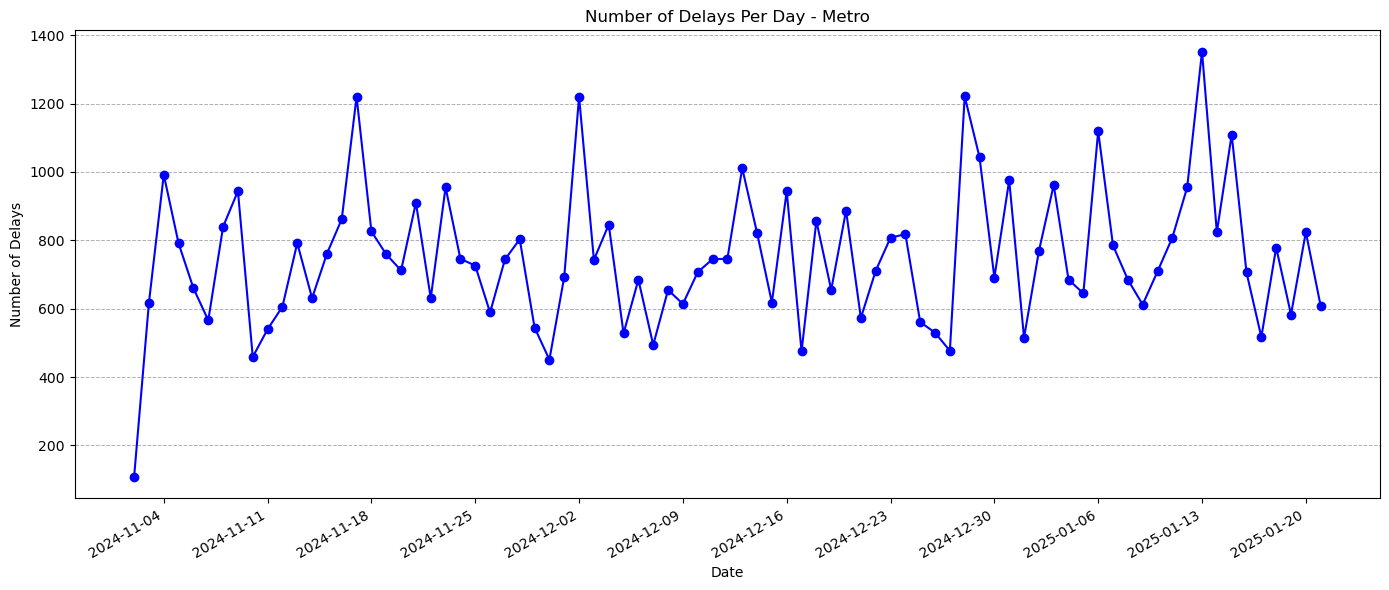

In [270]:
#Number of delays per days 
start_date = pd.to_datetime('2024-11-02 00:00:00')
merged_metro = merged_metro[(merged_metro['nearest_datetime'] >= start_date)]

merged_metro['nearest_datetime'] = pd.to_datetime(merged_metro['nearest_datetime'])
delayed_metro = merged_metro[merged_metro['departure_status'] == 'delayed']

delayed_count_per_day = delayed_metro.groupby(delayed_metro['nearest_datetime'].dt.date).size().reset_index(name='delay_count')
delayed_count_per_day.rename(columns={'nearest_datetime': 'date'}, inplace=True)
delayed_count_per_day['date'] = pd.to_datetime(delayed_count_per_day['date'])

plt.figure(figsize=(14, 6))
plt.plot(delayed_count_per_day['date'], delayed_count_per_day['delay_count'], marker='o', color="blue")

plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  #Major ticks every Monday
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  #Date format
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Number of Delays')
plt.title('Number of Delays Per Day - Metro')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig("./Figures/Delays-Per-Day-Weekly-Ticks-Alternating-Metro-all.png", format='png', dpi=300)
plt.show()

/var/folders/zs/vj5m58vj3339k9xrxfgmwjz40000gn/T/ipykernel_2130/1812987540.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delayed_metro['day_of_week'] = delayed_metro['nearest_datetime'].dt.day_name()
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence

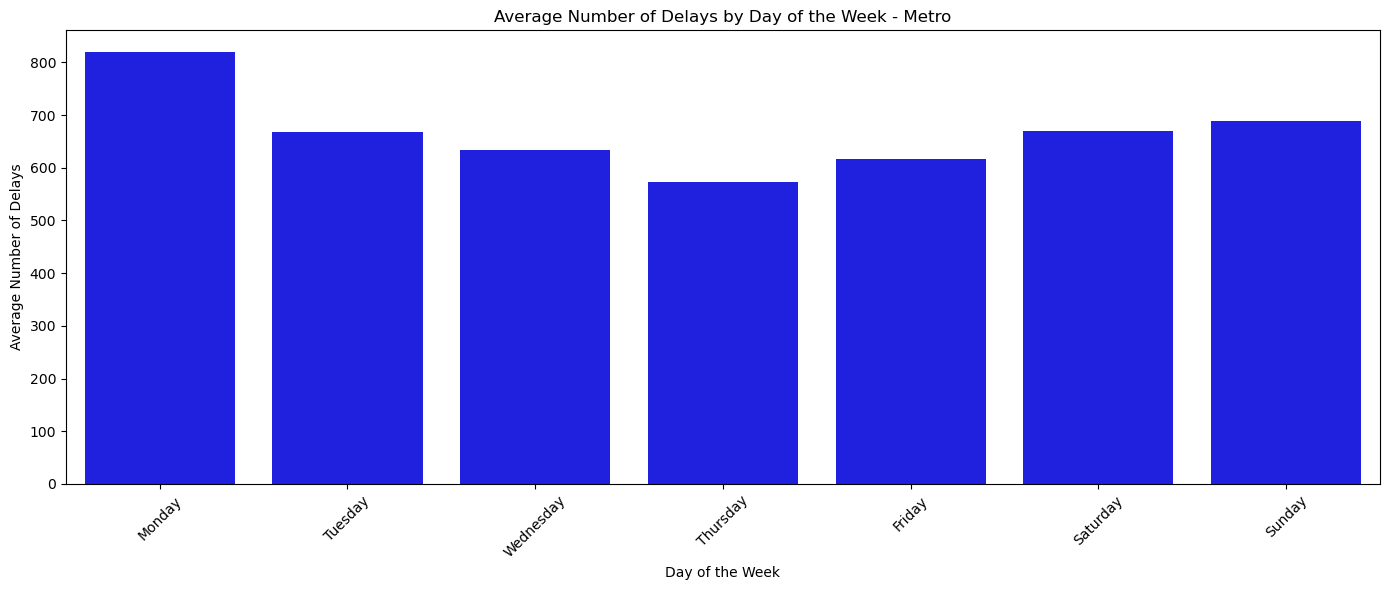

In [271]:
merged_metro['nearest_datetime'] = pd.to_datetime(merged_metro['nearest_datetime'])
delayed_metro = merged_metro[merged_metro['departure_status'] == 'delayed']
delayed_metro['day_of_week'] = delayed_metro['nearest_datetime'].dt.day_name()
delays_by_day = delayed_metro.groupby('day_of_week').size().reset_index(name='delay_count')

start_date = delayed_metro['nearest_datetime'].min().to_period('W').start_time
end_date = delayed_metro['nearest_datetime'].max().to_period('W').end_time
number_of_weeks = pd.date_range(start_date, end_date, freq='W').size

delays_by_day['avg_delays_per_day'] = delays_by_day['delay_count'] / number_of_weeks
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
delays_by_day['day_of_week'] = pd.Categorical(delays_by_day['day_of_week'], categories=days_order, ordered=True)
delays_by_day = delays_by_day.sort_values('day_of_week')

plt.figure(figsize=(14, 6))
sns.barplot(x='day_of_week', y='avg_delays_per_day', data=delays_by_day, color="blue")
plt.xlabel('Day of the Week')
plt.ylabel('Average Number of Delays')
plt.title('Average Number of Delays by Day of the Week - Metro')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./Figures/Average-Delays-by-Day-of-Week-Metro-all.png", format='png', dpi=300)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

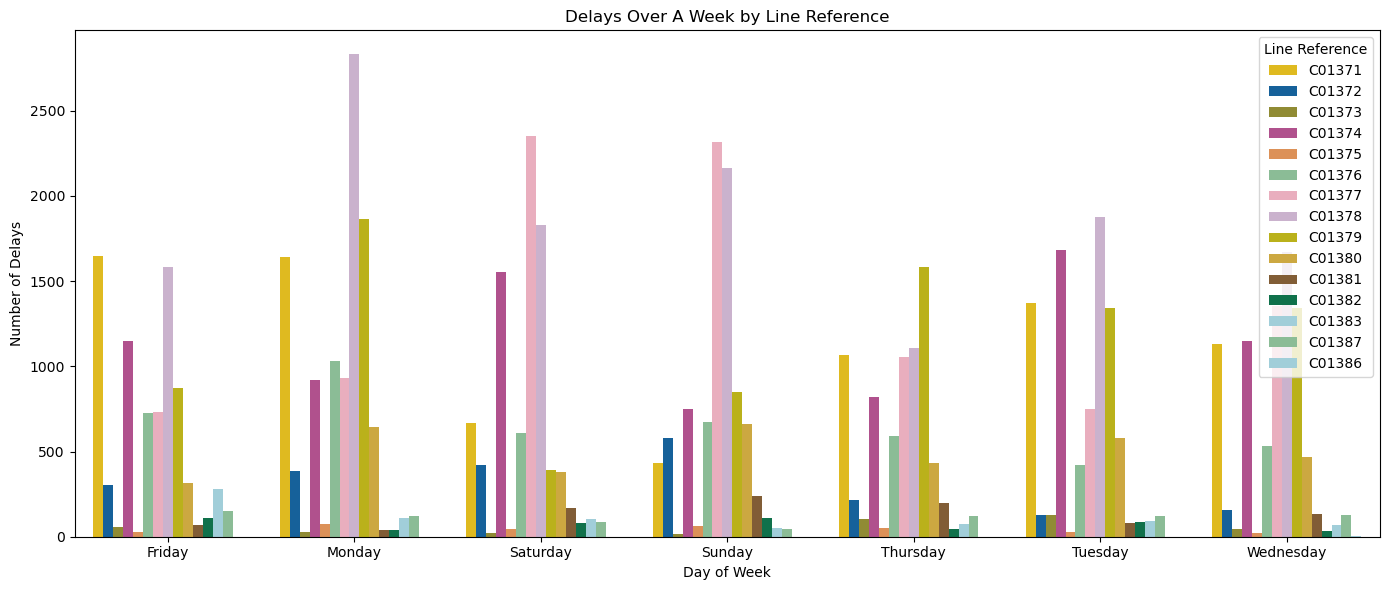

In [272]:
delayed_daily_summary = (
    delayed_metro.groupby(['day_of_week', 'line_ref']) #0 is monday
    .size()
    .reset_index(name='delay_count')
)

plt.figure(figsize=(14, 6))
sns.barplot(
    data=delayed_daily_summary,
    x='day_of_week',
    y='delay_count',
    hue='line_ref',
    palette=metro_line_palette
)
plt.xlabel('Day of Week')
plt.ylabel('Number of Delays')
plt.title('Delays Over A Week by Line Reference')
plt.legend(title='Line Reference', loc='upper right')
plt.tight_layout()
plt.savefig("./Figures/Delays-Week-Days-By-Line-Metro.png", format='png', dpi=300)
plt.show()

/var/folders/zs/vj5m58vj3339k9xrxfgmwjz40000gn/T/ipykernel_2130/1457539912.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delayed_metro['hour_of_day'] = delayed_metro['nearest_datetime'].dt.hour


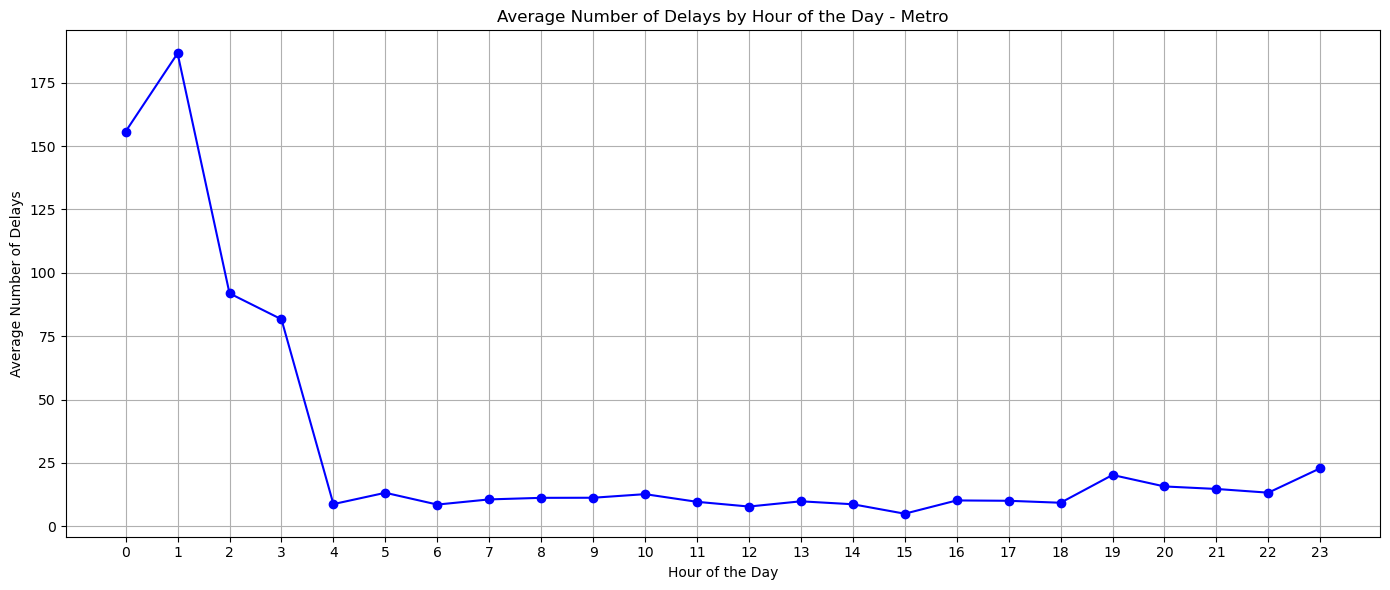

In [273]:
merged_metro['nearest_datetime'] = pd.to_datetime(merged_metro['nearest_datetime'])
delayed_metro = merged_metro[merged_metro['departure_status'] == 'delayed']
delayed_metro['hour_of_day'] = delayed_metro['nearest_datetime'].dt.hour
delays_by_hour = delayed_metro.groupby('hour_of_day').size().reset_index(name='delay_count')

start_date = delayed_metro['nearest_datetime'].min().date()
end_date = delayed_metro['nearest_datetime'].max().date()
number_of_days = (end_date - start_date).days + 1  # +1 to include the last day

delays_by_hour['avg_delays_per_hour'] = delays_by_hour['delay_count'] / number_of_days
delays_by_hour = delays_by_hour.sort_values('hour_of_day')

plt.figure(figsize=(14, 6))
plt.plot(delays_by_hour['hour_of_day'], delays_by_hour['avg_delays_per_hour'], marker='o', color="blue")
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Delays')
plt.title('Average Number of Delays by Hour of the Day - Metro')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.savefig("./Figures/Average-Delays-by-Hour-of-Day-Metro-Line.png", format='png', dpi=300)
plt.show()

In [274]:
metro_line_palette = {
    'C01371': '#FFCE00', #Metro_1
    'C01372': '#0064B0', #Metro_2
    'C01373': '#9F9825', #Metro_3
    'C01374': '#C04191', #Metro_4
    'C01375': '#F28E42', #Metro_5
    'C01376': '#83C491', #Metro_6
    'C01377': '#F3A4BA', #Metro_7
    'C01378': '#CEADD2', #Metro_8
    'C01379': '#D5C900', #Metro_9
    'C01380': '#E3B32A', #Metro_10
    'C01381': '#8D5E2A', #Metro_11
    'C01382': '#00814F', #Metro_12
    'C01383': '#98D4E2', #Metro_13
    'C01384': '#662483', #Metro_14
    'C01386': '#98D4E2', #Metro_3B
    'C01387': '#83C491'  #Metro_7B
}

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


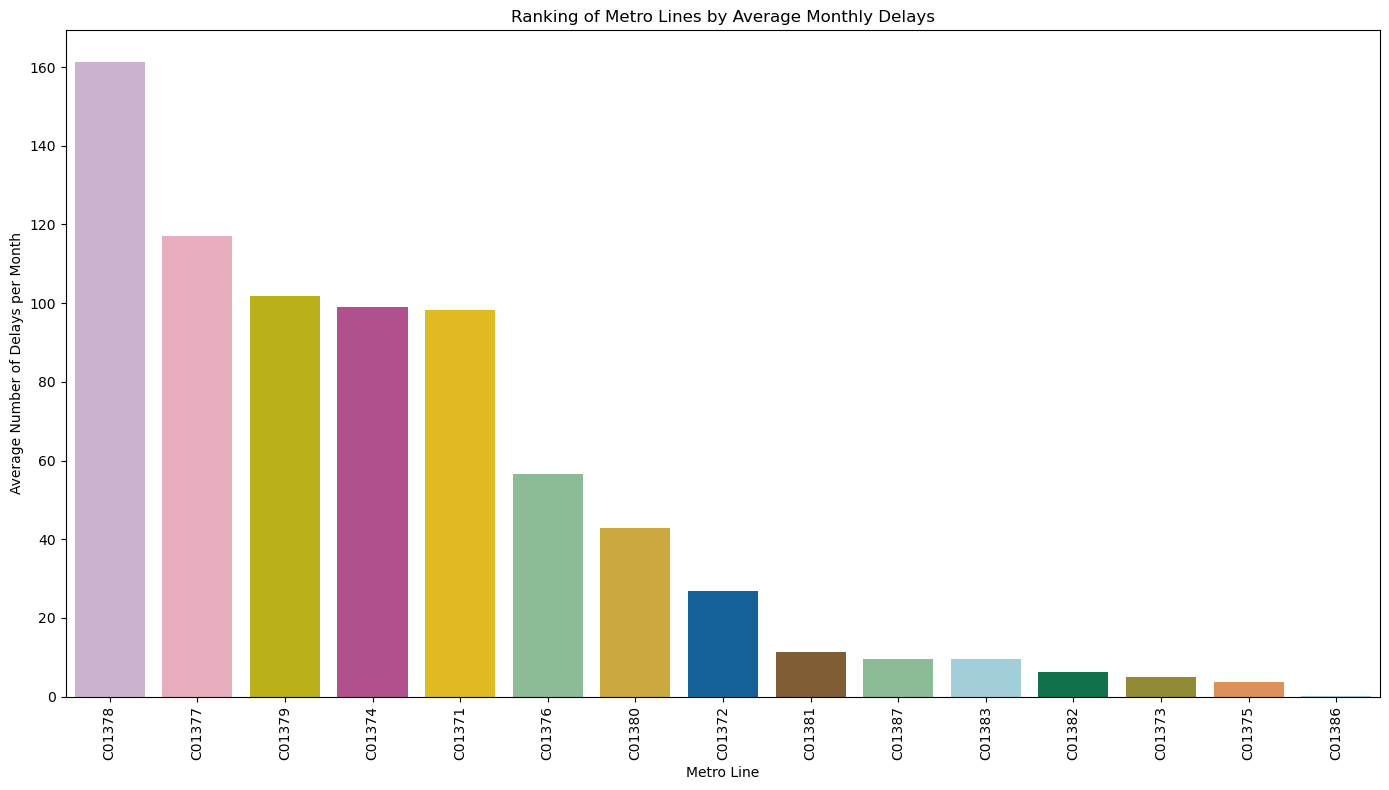

In [275]:
#Line with the most incidengts (bar ) / Classification of each line

#Group by 'line_ref' to get total delay counts for each line
total_delays_per_line = (
    delayed_metro.groupby('line_ref')
    .size()
    .reset_index(name='total_delays')
)

unique_days = delayed_metro['Date'].nunique()
total_delays_per_line['avg_delays_over_the_period'] = total_delays_per_line['total_delays'] / unique_days
total_delays_per_line_sorted = total_delays_per_line.sort_values('avg_delays_over_the_period', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=total_delays_per_line_sorted,
    x='line_ref',
    y='avg_delays_over_the_period',
    palette=metro_line_palette 
)
plt.xticks(rotation=90)
plt.xlabel('Metro Line')
plt.ylabel('Average Number of Delays per Month')
plt.title('Ranking of Metro Lines by Average Monthly Delays')
plt.tight_layout()
plt.savefig("./Figures/Metro-Line-Ranking-by-Delays.png", format='png', dpi=300)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

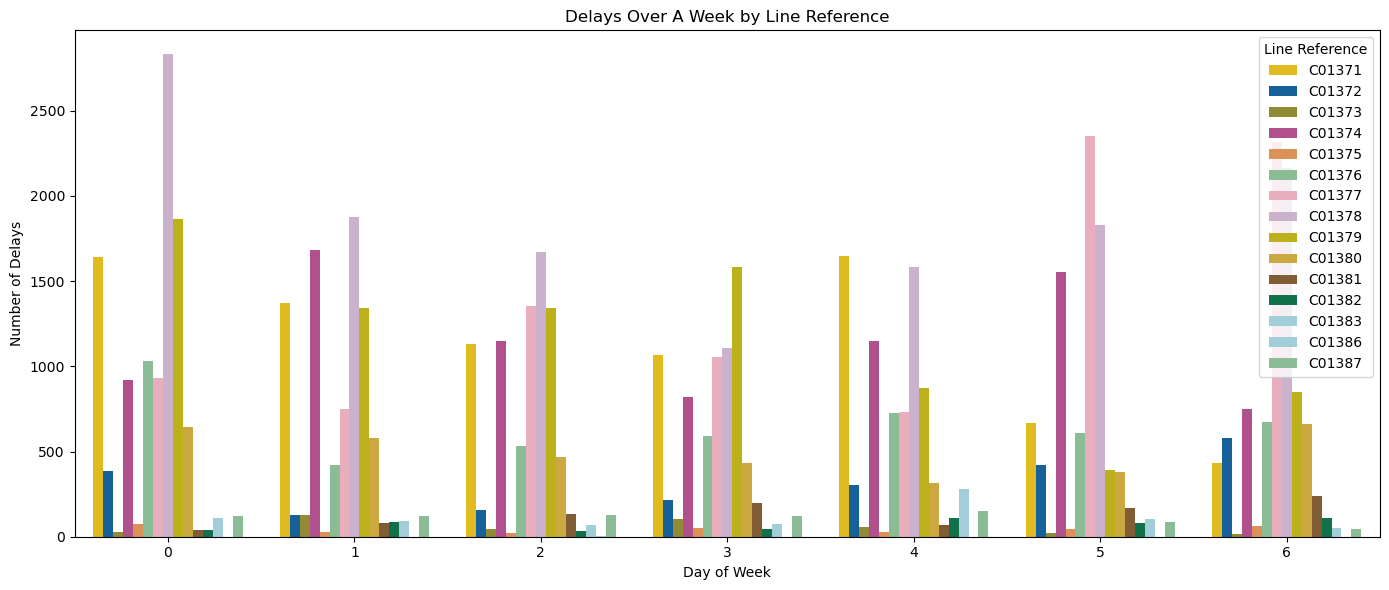

In [276]:
delayed_daily_summary = (
    delayed_metro.groupby(['day_of_week', 'line_ref']) #0 is monday
    .size()
    .reset_index(name='delay_count')
)

# Set up the plot
plt.figure(figsize=(14, 6))

# Bar plot grouped by day_of_month with color-coded line_ref
sns.barplot(
    data=delayed_daily_summary,
    x='day_of_week',
    y='delay_count',
    hue='line_ref',  # Color separation by line_ref
    palette=metro_line_palette
)

# Add labels and title
plt.xlabel('Day of Week')
plt.ylabel('Number of Delays')
plt.title('Delays Over A Week by Line Reference')

# Adjust ticks for better readability

# Enable legend
plt.legend(title='Line Reference', loc='upper right')

# Tight layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig("./Figures/Delays-Week-Days-By-Line.png", format='png', dpi=300)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

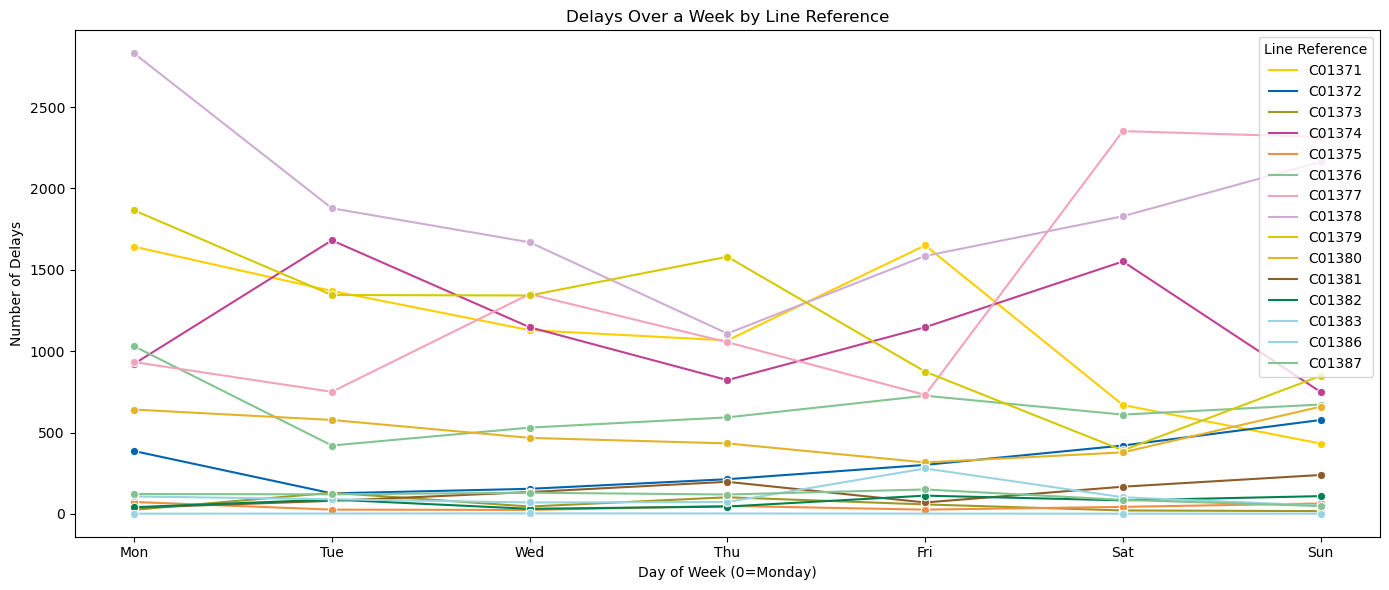

In [277]:
# same thing but line plot

# Group by day_of_week and line_ref
delayed_daily_summary = (
    delayed_metro.groupby(['day_of_week', 'line_ref'])  # 0 is Monday
    .size()
    .reset_index(name='delay_count')
)

# Set up the plot
plt.figure(figsize=(14, 6))

# Line plot with scatter points
sns.lineplot(
    data=delayed_daily_summary,
    x='day_of_week',
    y='delay_count',
    hue='line_ref',  # Color separation by line_ref
    marker='o',  # Add scatter points
    palette=metro_line_palette
)

# Add labels and title
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Number of Delays')
plt.title('Delays Over a Week by Line Reference')

# Set x-ticks to represent days of the week (0=Monday, 6=Sunday)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Enable legend
plt.legend(title='Line Reference', loc='upper right')

# Tight layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig("./Figures/Delays-Week-Days-Line-Scatter.png", format='png', dpi=300)
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

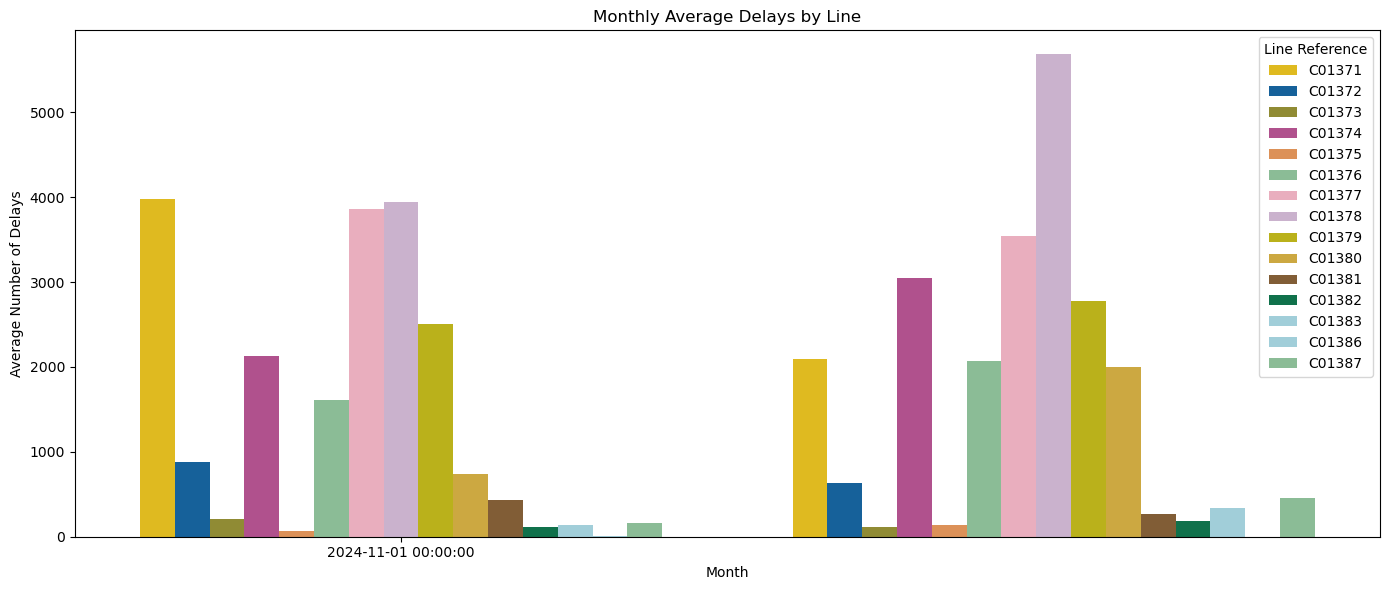

In [278]:
merged_metro['nearest_datetime'] = pd.to_datetime(merged_metro['nearest_datetime'])

delayed_metro = merged_metro[merged_metro['departure_status'] == 'delayed']

start_date = pd.to_datetime('2024-11-02 00:00:00')
end_date = pd.to_datetime('2024-12-31 23:59:59')

delayed_metro = delayed_metro[(delayed_metro['nearest_datetime'] >= start_date) & (delayed_metro['nearest_datetime'] <= end_date)]


# Extract month and year for grouping
delayed_metro['year_month'] = delayed_metro['nearest_datetime'].dt.to_period('M')

# Group by 'year_month' and 'line_ref' and count delays
monthly_avg_delays = (
    delayed_metro.groupby(['year_month', 'line_ref'])
    .size()
    .reset_index(name='delay_count')
)


# Convert 'year_month' back to datetime for plotting
monthly_avg_delays['year_month'] = monthly_avg_delays['year_month'].dt.to_timestamp()

# Set up the plot
plt.figure(figsize=(14, 6))

# Create the bar plot with color separation by 'line_ref'
sns.barplot(
    data=monthly_avg_delays,
    x='year_month',
    y='delay_count',
    hue='line_ref',  # Color separation by line_ref
    palette=metro_line_palette  # Seaborn palette for color separation
)

# Format the x-axis for better date handling
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to months
## add proper novermber december tickers!!


# Add labels and title
plt.xlabel('Month')
plt.ylabel('Average Number of Delays')
plt.title('Monthly Average Delays by Line')

# Enable legend
plt.legend(title='Line Reference', loc='upper right')

# Tight layout for better spacing
plt.tight_layout()

# Save and display the plot
plt.savefig("./Figures/Monthly-Delays-By-Line.png", format='png', dpi=300)
plt.show()

## RER

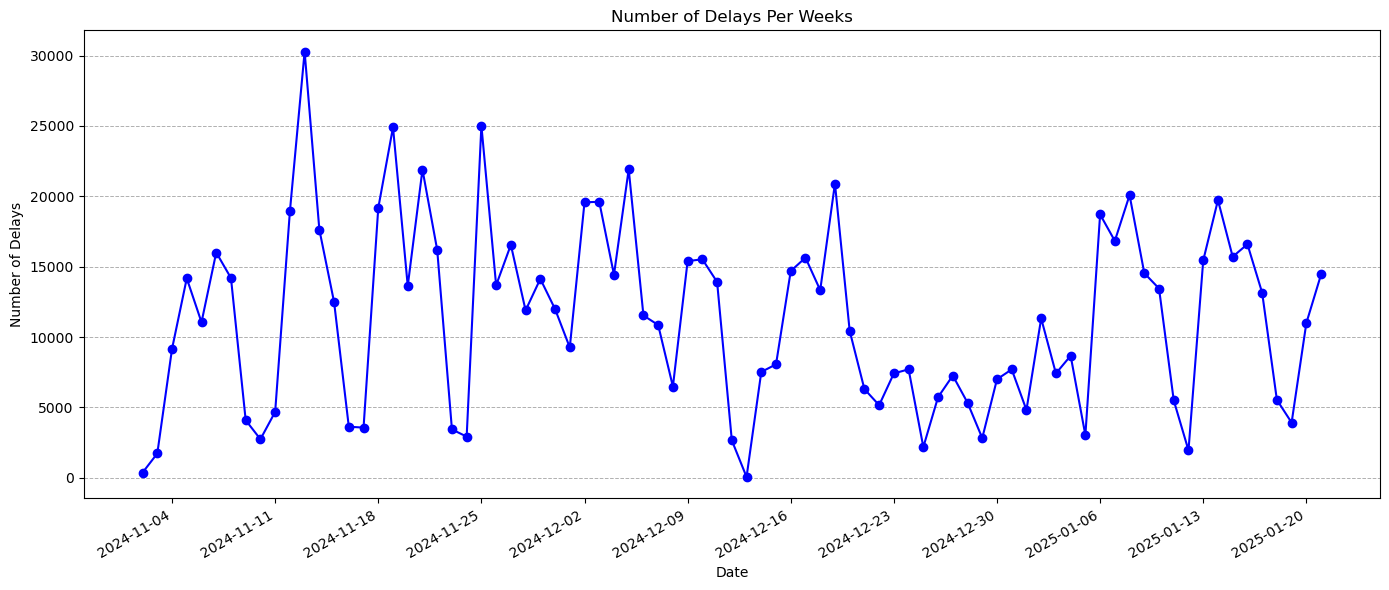

In [280]:
#Number of delays per days 
start_date = pd.to_datetime('2024-11-02 00:00:00')
merged_rer = merged_rer[(merged_rer['nearest_datetime'] >= start_date)]

merged_rer['nearest_datetime'] = pd.to_datetime(merged_rer['nearest_datetime'])
delayed_rer = merged_rer[merged_rer['departure_status'] == 'delayed']
delayed_count_per_day = delayed_rer.groupby(delayed_rer['nearest_datetime'].dt.date).size().reset_index(name='delay_count')
delayed_count_per_day.rename(columns={'nearest_datetime': 'date'}, inplace=True)
delayed_count_per_day['date'] = pd.to_datetime(delayed_count_per_day['date'])

plt.figure(figsize=(14, 6))
plt.plot(delayed_count_per_day['date'], delayed_count_per_day['delay_count'], marker='o', color="blue")
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  #Major ticks every Monday
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  #Date format
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Number of Delays')
plt.title('Number of Delays Per Weeks')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig("./Figures/Delays-Per-Day-Weekly-Ticks-Alternating-RER.png", format='png', dpi=300)
plt.show()

/var/folders/zs/vj5m58vj3339k9xrxfgmwjz40000gn/T/ipykernel_2130/797051983.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delayed_rer['day_of_week'] = delayed_rer['nearest_datetime'].dt.day_name()
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this

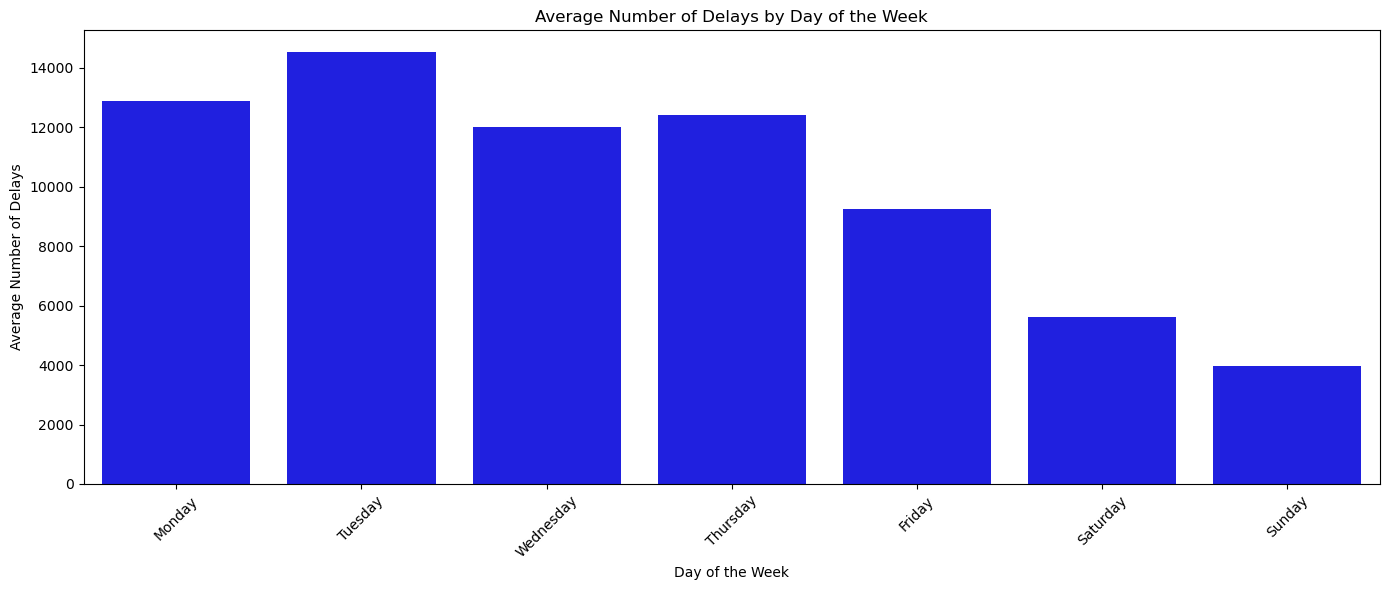

In [281]:
#Number of delays per days
delayed_rer = merged_rer[merged_rer['departure_status'] == 'delayed']
delayed_rer['day_of_week'] = delayed_rer['nearest_datetime'].dt.day_name()
delays_by_day = delayed_rer.groupby('day_of_week').size().reset_index(name='delay_count')

start_date = delayed_rer['nearest_datetime'].min().to_period('W').start_time
end_date = delayed_rer['nearest_datetime'].max().to_period('W').end_time

number_of_weeks = pd.date_range(start_date, end_date, freq='W').size
delays_by_day['avg_delays_per_day'] = delays_by_day['delay_count'] / number_of_weeks
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
delays_by_day['day_of_week'] = pd.Categorical(delays_by_day['day_of_week'], categories=days_order, ordered=True)
delays_by_day = delays_by_day.sort_values('day_of_week')

plt.figure(figsize=(14, 6))
sns.barplot(x='day_of_week', y='avg_delays_per_day', data=delays_by_day, color="blue")
plt.xlabel('Day of the Week')
plt.ylabel('Average Number of Delays')
plt.title('Average Number of Delays by Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./Figures/Average-Delays-by-Day-of-Week-RER.png", format='png', dpi=300)
plt.show()

/var/folders/zs/vj5m58vj3339k9xrxfgmwjz40000gn/T/ipykernel_2130/2266136869.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delayed_rer['hour_of_day'] = delayed_rer['nearest_datetime'].dt.hour


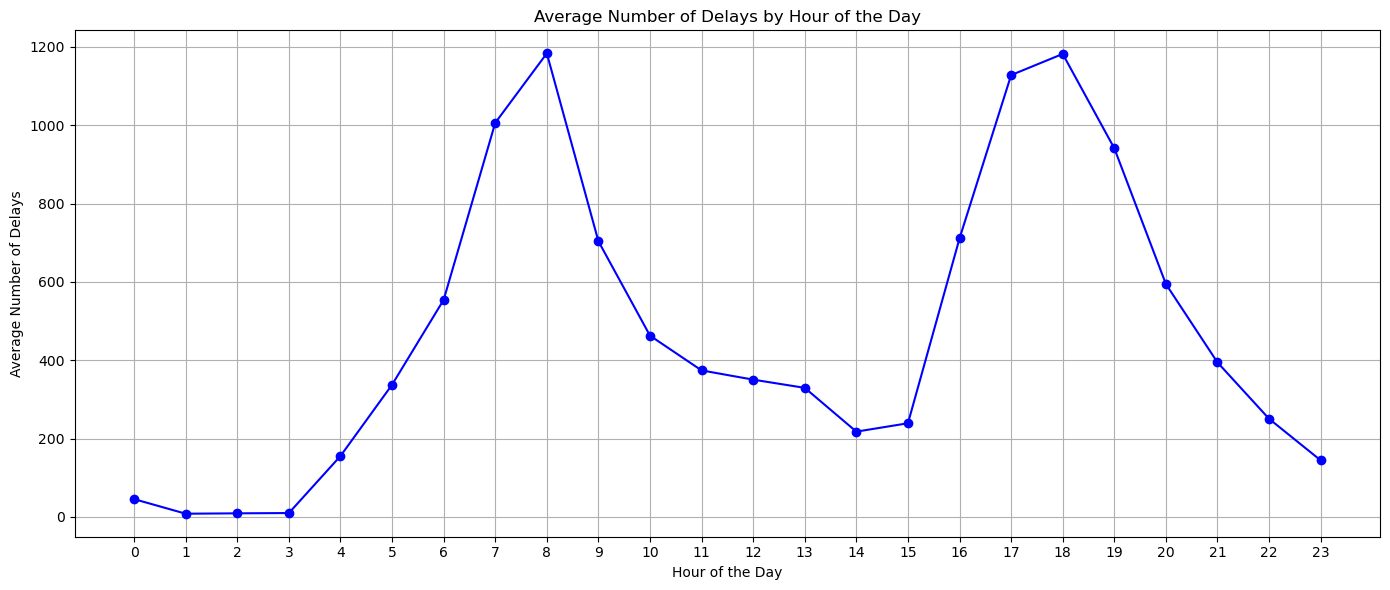

In [282]:
#Number of delays per hours
delayed_rer = merged_rer[merged_rer['departure_status'] == 'delayed']
delayed_rer['hour_of_day'] = delayed_rer['nearest_datetime'].dt.hour
delays_by_hour = delayed_rer.groupby('hour_of_day').size().reset_index(name='delay_count')

start_date = delayed_rer['nearest_datetime'].min().date()
end_date = delayed_rer['nearest_datetime'].max().date()
number_of_days = (end_date - start_date).days + 1  # +1 to include the last day

delays_by_hour['avg_delays_per_hour'] = delays_by_hour['delay_count'] / number_of_days
delays_by_hour = delays_by_hour.sort_values('hour_of_day')

plt.figure(figsize=(14, 6))
plt.plot(delays_by_hour['hour_of_day'], delays_by_hour['avg_delays_per_hour'], marker='o', color="blue")
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Delays')
plt.title('Average Number of Delays by Hour of the Day')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.savefig("./Figures/Average-Delays-by-Hour-of-Day-Line-RER.png", format='png', dpi=300)
plt.show()

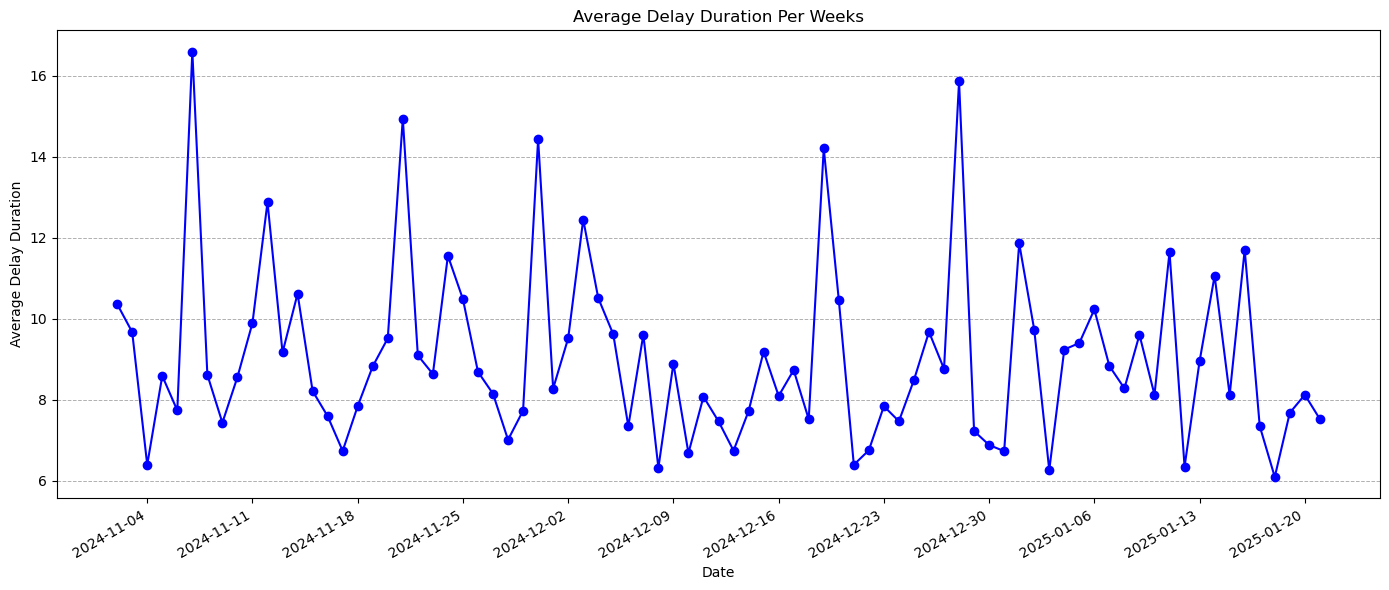

In [283]:
#Delays duration per days 
merged_rer['arrival_difference'] = merged_rer['arrival_difference'].fillna(0).astype(int)
merged_rer_filtered = merged_rer[merged_rer['arrival_difference'] <= 100].copy()   #we removed outliers for better readability
merged_rer_filtered['hour'] = merged_rer_filtered['nearest_datetime'].dt.hour
delayed_rer = merged_rer_filtered[merged_rer_filtered['departure_status'] == 'delayed']

daily_avg_delay_duration = delayed_rer.groupby(delayed_rer['nearest_datetime'].dt.date)['arrival_difference'].mean().reset_index()
daily_avg_delay_duration.rename(columns={'nearest_datetime': 'date', 'arrival_difference': 'avg_delay_duration'}, inplace=True)
daily_avg_delay_duration['date'] = pd.to_datetime(daily_avg_delay_duration['date'])

plt.figure(figsize=(14, 6))
plt.plot(daily_avg_delay_duration['date'], daily_avg_delay_duration['avg_delay_duration'], marker='o', color="blue")
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # Major ticks every Monday
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Date format
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Average Delay Duration')
plt.title('Average Delay Duration Per Weeks')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig("./Figures/Avg-Delay-Duration-Per-Day-RER.png", format='png', dpi=300)
plt.show()


/var/folders/zs/vj5m58vj3339k9xrxfgmwjz40000gn/T/ipykernel_2130/1157022123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delayed_rer['day_of_week'] = delayed_rer['nearest_datetime'].dt.day_name()
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence thi

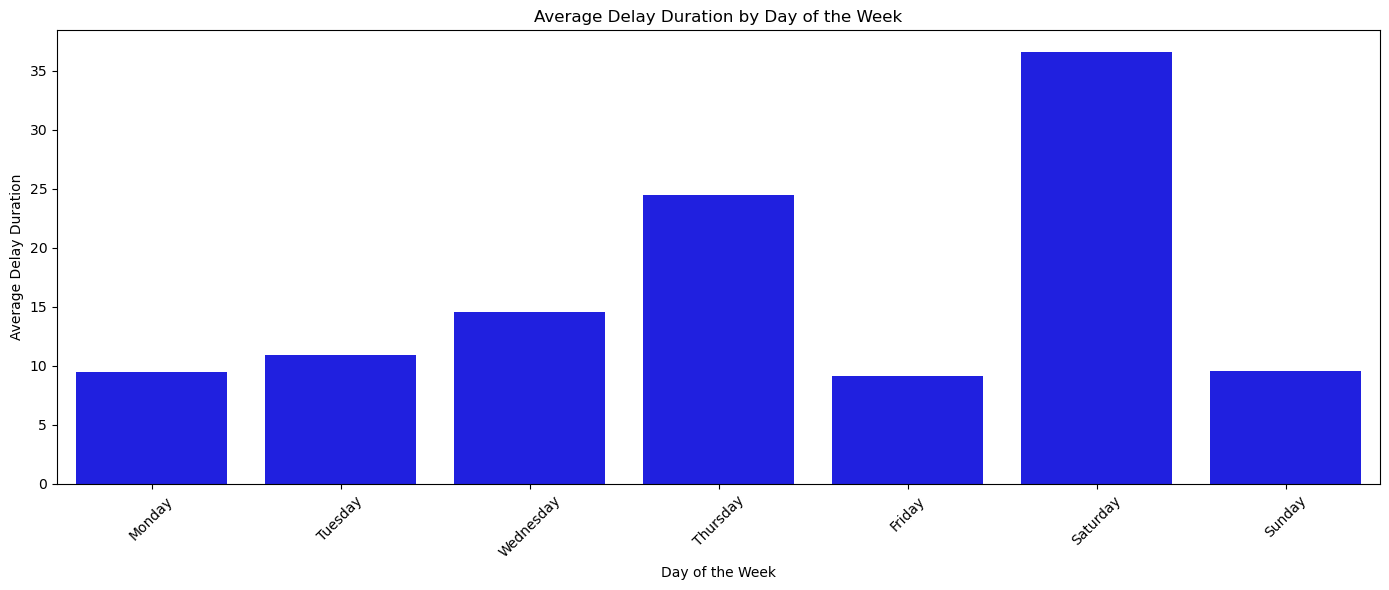

In [284]:
#Avg delays durations by day of the week
delayed_rer = merged_rer[merged_rer['departure_status'] == 'delayed']
delayed_rer['day_of_week'] = delayed_rer['nearest_datetime'].dt.day_name()
avg_delay_duration_by_day = delayed_rer.groupby('day_of_week')['arrival_difference'].mean().reset_index()
avg_delay_duration_by_day.rename(columns={'arrival_difference': 'avg_delay_duration'}, inplace=True)

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_delay_duration_by_day['day_of_week'] = pd.Categorical(avg_delay_duration_by_day['day_of_week'], categories=days_order, ordered=True)
avg_delay_duration_by_day = avg_delay_duration_by_day.sort_values('day_of_week')

plt.figure(figsize=(14, 6))
sns.barplot(x='day_of_week', y='avg_delay_duration', data=avg_delay_duration_by_day, color="blue")
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay Duration')
plt.title('Average Delay Duration by Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./Figures/Average-Delay-Duration-by-Day-of-Week-RER.png", format='png', dpi=300)
plt.show()

/var/folders/zs/vj5m58vj3339k9xrxfgmwjz40000gn/T/ipykernel_2130/2091479422.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delayed_rer['hour_of_day'] = delayed_rer['nearest_datetime'].dt.hour


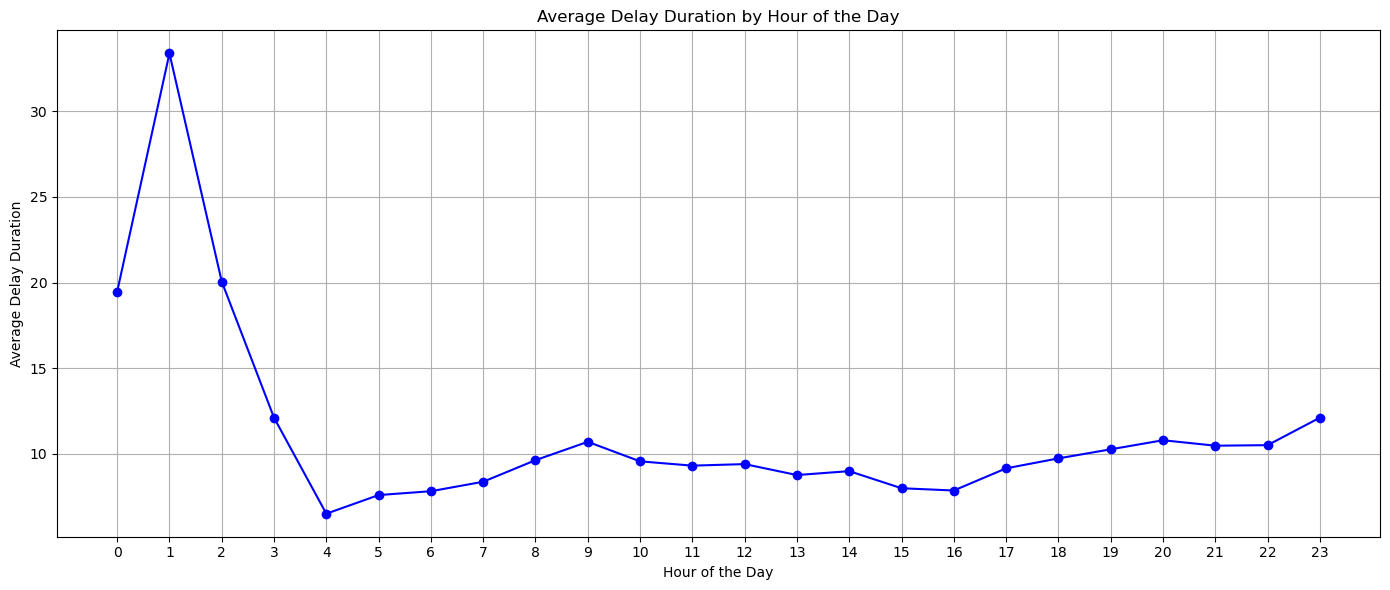

In [285]:
#Avg delays durations by hours of the day
merged_rer_filtered = merged_rer[merged_rer['arrival_difference'] <= 100].copy()   #we removed outliers for better readability
merged_rer_filtered['hour'] = merged_rer_filtered['nearest_datetime'].dt.hour 
merged_rer_filtered['nearest_datetime'] = pd.to_datetime(merged_rer_filtered['nearest_datetime'])
delayed_rer = merged_rer_filtered[merged_rer_filtered['departure_status'] == 'delayed']
delayed_rer['hour_of_day'] = delayed_rer['nearest_datetime'].dt.hour

avg_delay_duration_by_hour = delayed_rer.groupby('hour_of_day')['arrival_difference'].mean().reset_index()
avg_delay_duration_by_hour.rename(columns={'arrival_difference': 'avg_delay_duration'}, inplace=True)
avg_delay_duration_by_hour = avg_delay_duration_by_hour.sort_values('hour_of_day')

plt.figure(figsize=(14, 6))
plt.plot(avg_delay_duration_by_hour['hour_of_day'], avg_delay_duration_by_hour['avg_delay_duration'], marker='o', color="blue")
plt.xlabel('Hour of the Day')
plt.ylabel('Average Delay Duration')
plt.title('Average Delay Duration by Hour of the Day')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.savefig("./Figures/Average-Delay-Duration-by-Hour-of-Day-RER-Line.png", format='png', dpi=300)
plt.show()

In [286]:
rer_line_palette = {
    'C01743':'#4B92DB',        #RER B
    'C01742' :'#F7403A',       #RER A
    'C01727':'#F3D311',        #RER C
    'C01728':'#3F9C35',        #RER D
    'C01729':'#DE81D3'         #RER E
}

/var/folders/zs/vj5m58vj3339k9xrxfgmwjz40000gn/T/ipykernel_2130/2242422805.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delayed_rer['Date'] = delayed_rer['nearest_datetime'].dt.date
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_

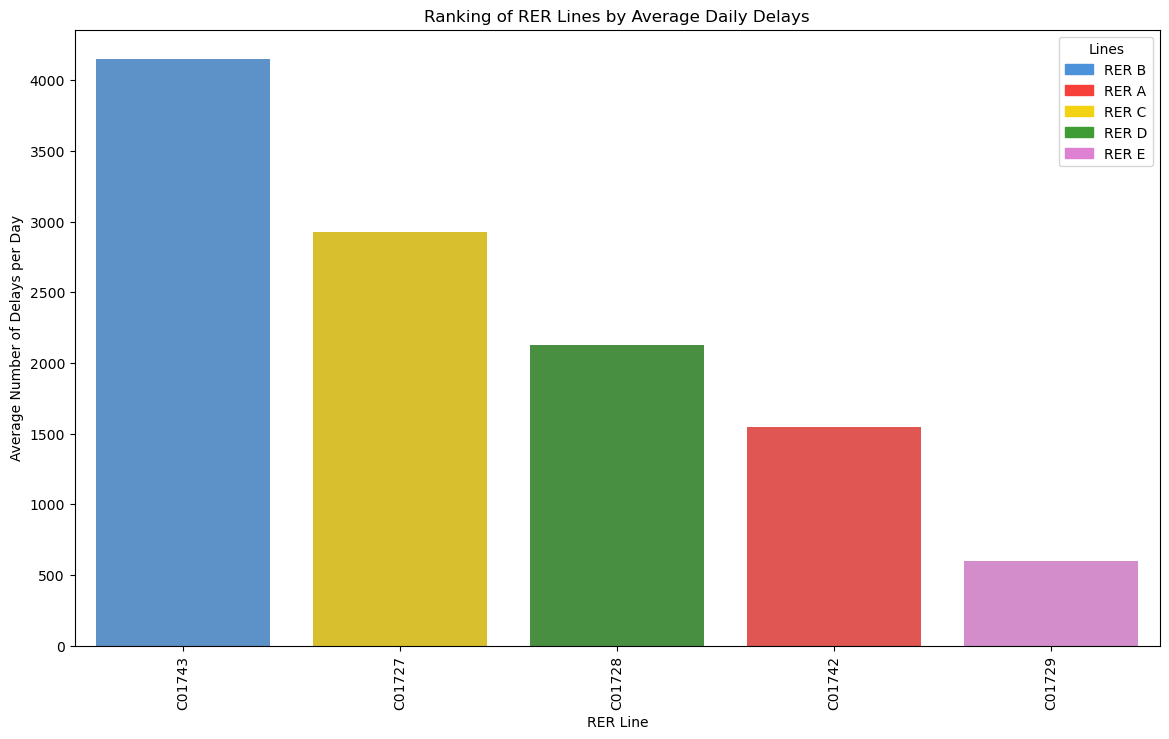

In [287]:
#Ranking by the amount of delays 
delayed_rer = merged_rer[merged_rer['departure_status'] == 'delayed']
total_delays_per_line = (
    delayed_rer.groupby('line_ref')
    .size()
    .reset_index(name='total_delays')
)
delayed_rer['Date'] = delayed_rer['nearest_datetime'].dt.date
unique_days = delayed_rer['Date'].nunique()
total_delays_per_line['avg_delays_per_day'] = total_delays_per_line['total_delays'] / unique_days

line_name_mapping = {
    'C01743': 'RER B',
    'C01742': 'RER A',
    'C01727': 'RER C',
    'C01728': 'RER D',
    'C01729': 'RER E'
}

total_delays_per_line_sorted = total_delays_per_line.sort_values('avg_delays_per_day', ascending=False)
total_delays_per_line_sorted['line_name'] = total_delays_per_line_sorted['line_ref'].map(line_name_mapping)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=total_delays_per_line_sorted,
    x='line_ref',
    y='avg_delays_per_day',
    palette=rer_line_palette 
)
plt.xticks(rotation=90)
handles = [plt.Rectangle((0,0),1,1, color=rer_line_palette[key]) for key in rer_line_palette.keys()]
labels = [line_name_mapping[key] for key in rer_line_palette.keys()]
plt.legend(handles, labels, title="Lines", loc='upper right')
plt.xlabel('RER Line')
plt.ylabel('Average Number of Delays per Day')
plt.title('Ranking of RER Lines by Average Daily Delays')
plt.savefig("./Figures/RER-Lines-Ranking-by-Average-Daily-Delays.png", format='png', dpi=300)
plt.show()

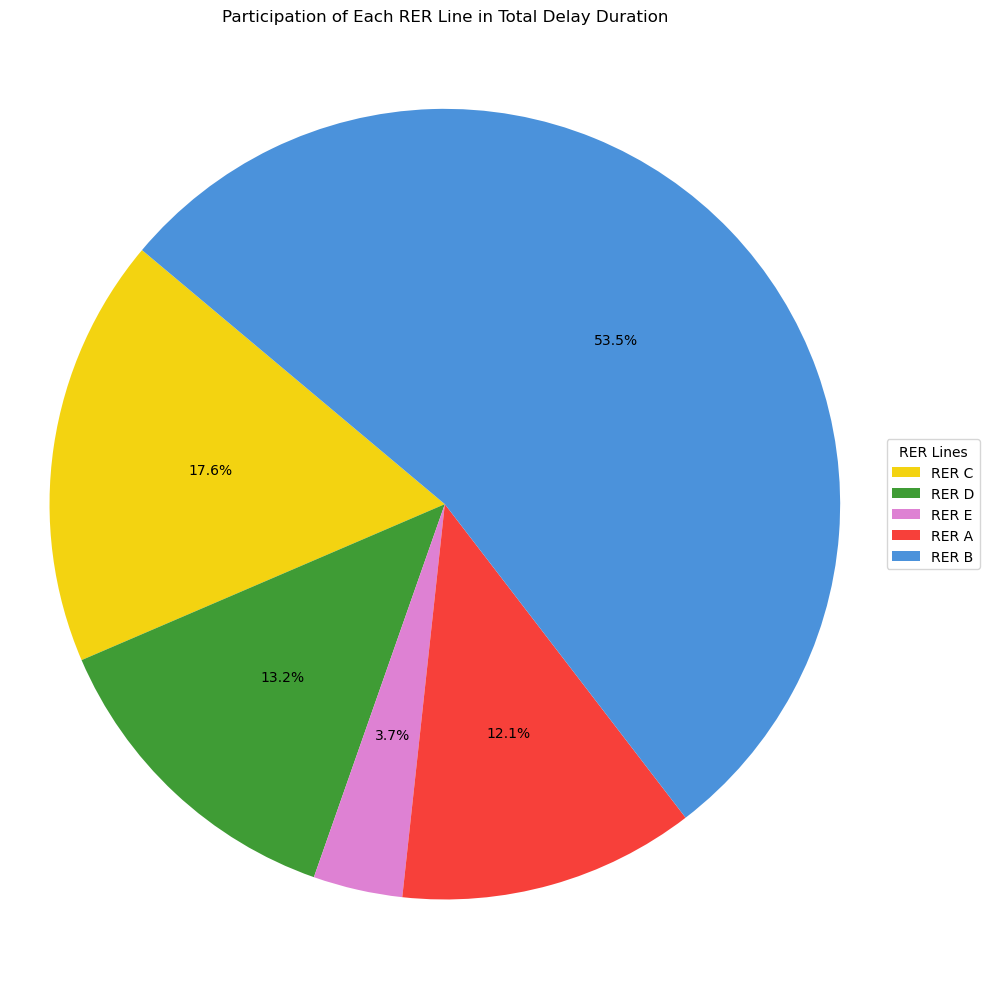

In [289]:
#Pie for the total duratio delays
delayed_rer = merged_rer[merged_rer['departure_status'] == 'delayed']

line_name_mapping = {
    'C01743': 'RER B',
    'C01742': 'RER A',
    'C01727': 'RER C',
    'C01728': 'RER D',
    'C01729': 'RER E'
}

line_delay_duration = delayed_rer.groupby('line_ref')['arrival_difference'].sum()

participation_percentage = (line_delay_duration / line_delay_duration.sum()) * 100

labels = [line_name_mapping.get(line, line) for line in participation_percentage.index]
sizes = participation_percentage.values
colors = [rer_line_palette.get(line, '#FFFFFF') for line in participation_percentage.index]  # Use white for any line not in palette

plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Participation of Each RER Line in Total Delay Duration')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(wedges, labels, title="RER Lines", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.savefig("./Figures/RER-Lines-Pie_chart.png", format='png', dpi=300)
plt.show()


## individual 8 stops

In [291]:
APK = pd.read_csv("./Stations/APK.csv")
GBG = pd.read_csv("./Stations/GBG.csv")
CLH = pd.read_csv("./Stations/CLH.csv", low_memory=False)
MP = pd.read_csv("./Stations/MP.csv")

CDG = pd.read_csv("./Stations/CDG.csv")
SL = pd.read_csv("./Stations/SL.csv")
SGP = pd.read_csv("./Stations/SGP.csv")
BL = pd.read_csv("./Stations/BL.csv")

In [326]:
def plot_station_metrics(df):
    df['nearest_datetime'] = pd.to_datetime(df['nearest_datetime'])

    station_name = df['stop_name'].iloc[0]

    df['hour'] = df['nearest_datetime'].dt.hour

    hourly_metrics = df.groupby('hour').agg({
        'pourc_validations': 'mean',
        'departure_status': lambda x: (x == 'delayed').sum()  # Count delays where status is 'delayed'
    }).reset_index()
    
    unique_days = df['nearest_datetime'].dt.date.nunique()
    hourly_metrics['avg_delays'] = hourly_metrics['departure_status'] / unique_days if unique_days > 0 else 0

    fig, ax1 = plt.subplots(figsize=(14, 8))

    color = 'tab:blue'
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Average Validation Percentage (%)', color=color)
    ax1.plot(hourly_metrics['hour'], hourly_metrics['pourc_validations'], color=color, marker='o')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Average Number of Delays', color=color)  
    ax2.plot(hourly_metrics['hour'], hourly_metrics['avg_delays'], color=color, marker='o')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'Average Validation Percentage and Delays by Hour of Day for {station_name}')
    plt.xticks(range(24))
    
    ax1.grid(True)
    sanitized_station_name = station_name.replace(" ", "_").replace("/", "-")  # Sanitize filename
    plt.savefig(f"./Figures/{sanitized_station_name}_metrics.png", format='png', dpi=300)    
    fig.tight_layout()
    plt.show()


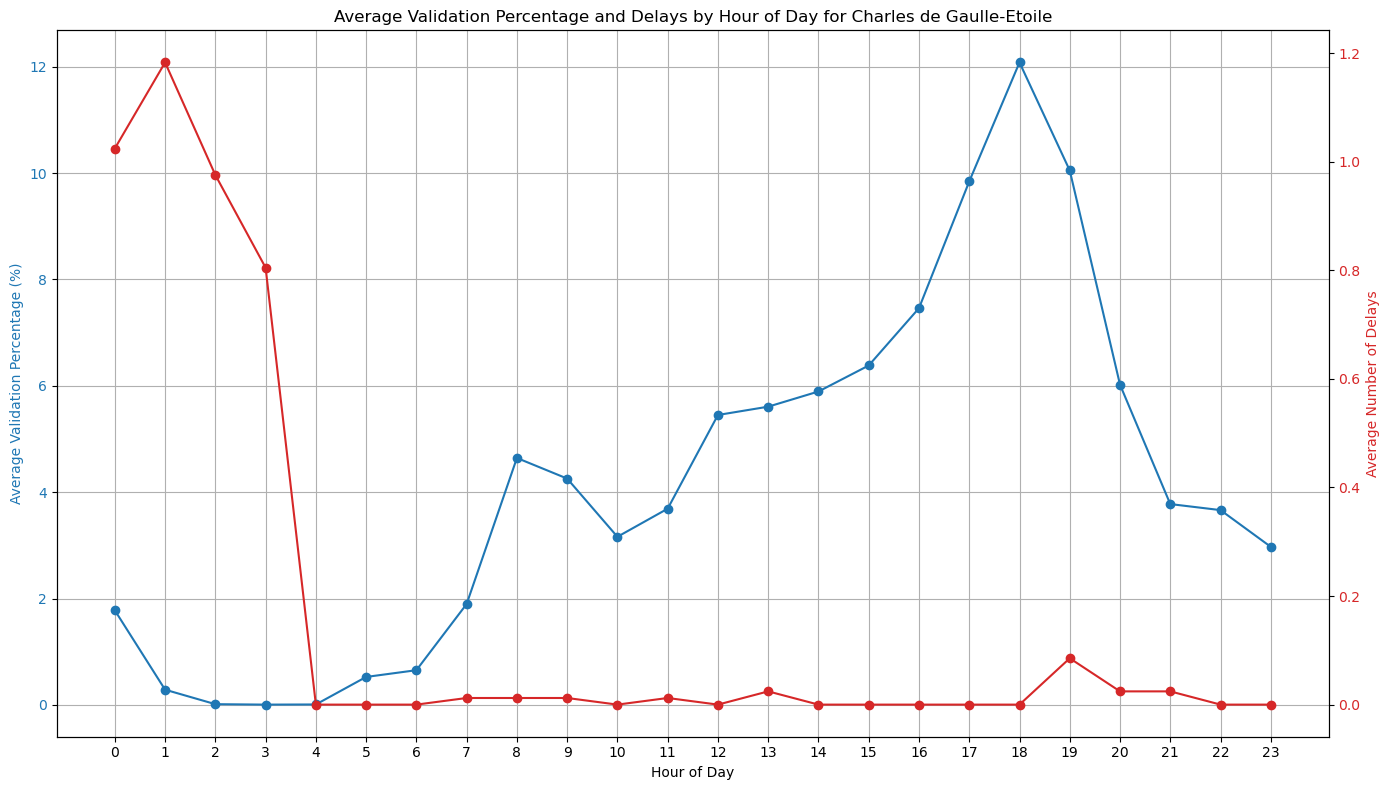

In [328]:
plot_station_metrics(CDG)

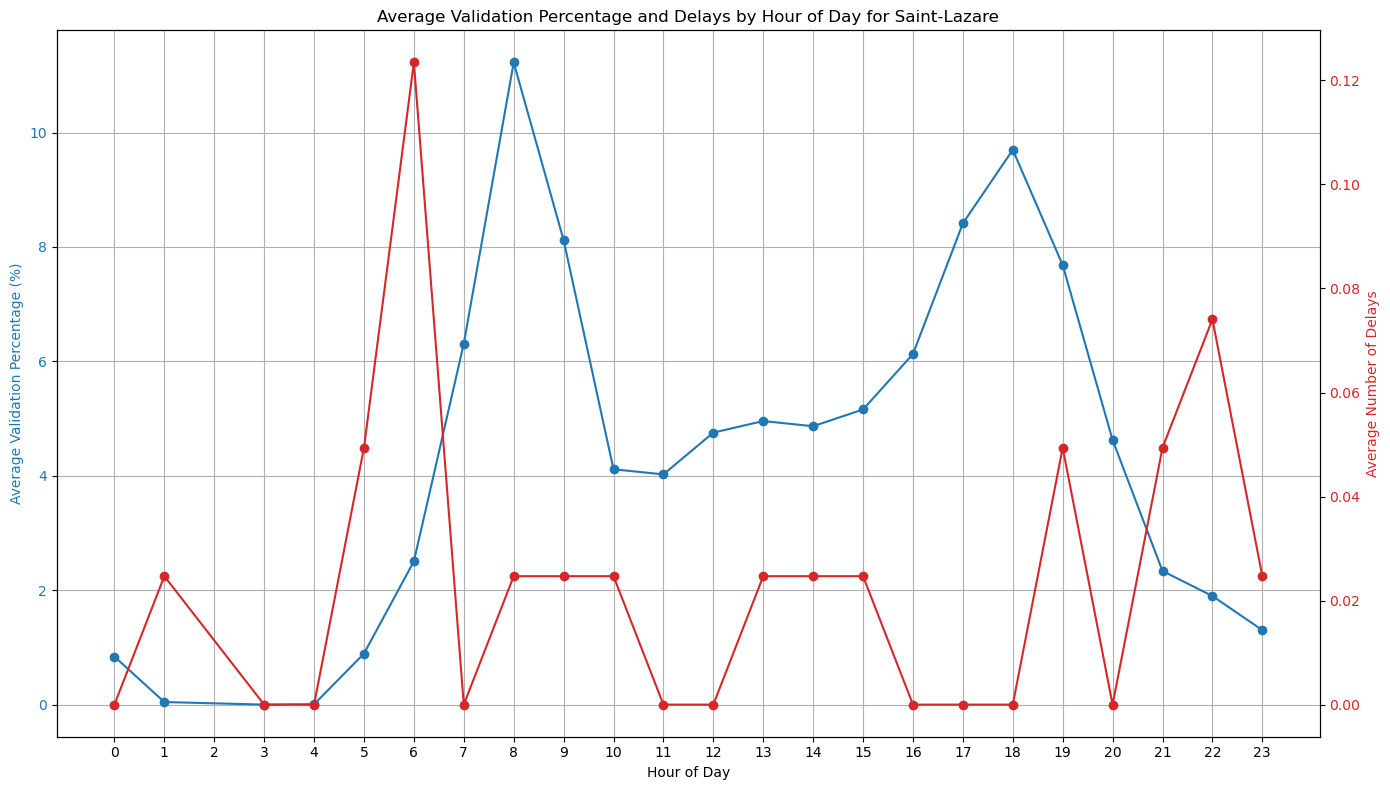

In [330]:
plot_station_metrics(SL)

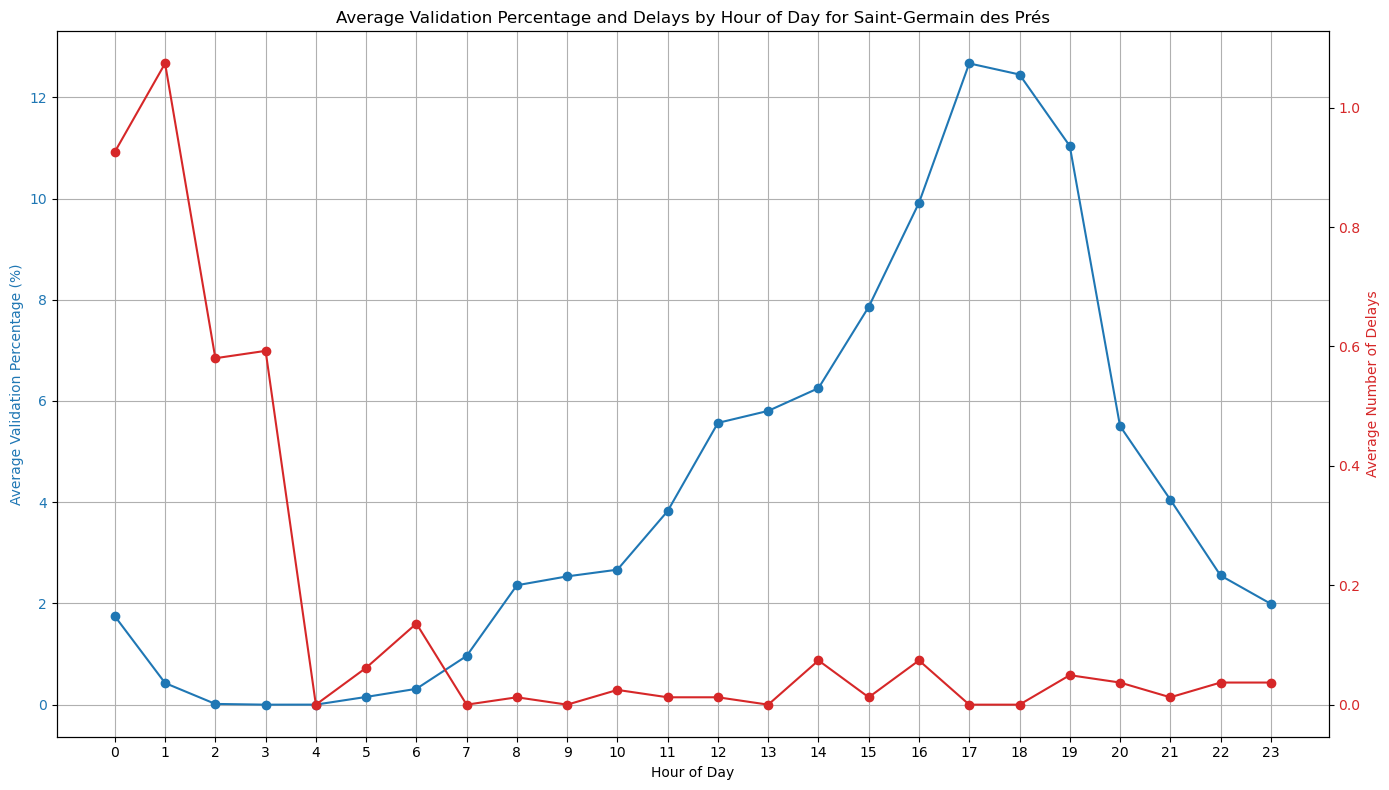

In [331]:
plot_station_metrics(SGP)

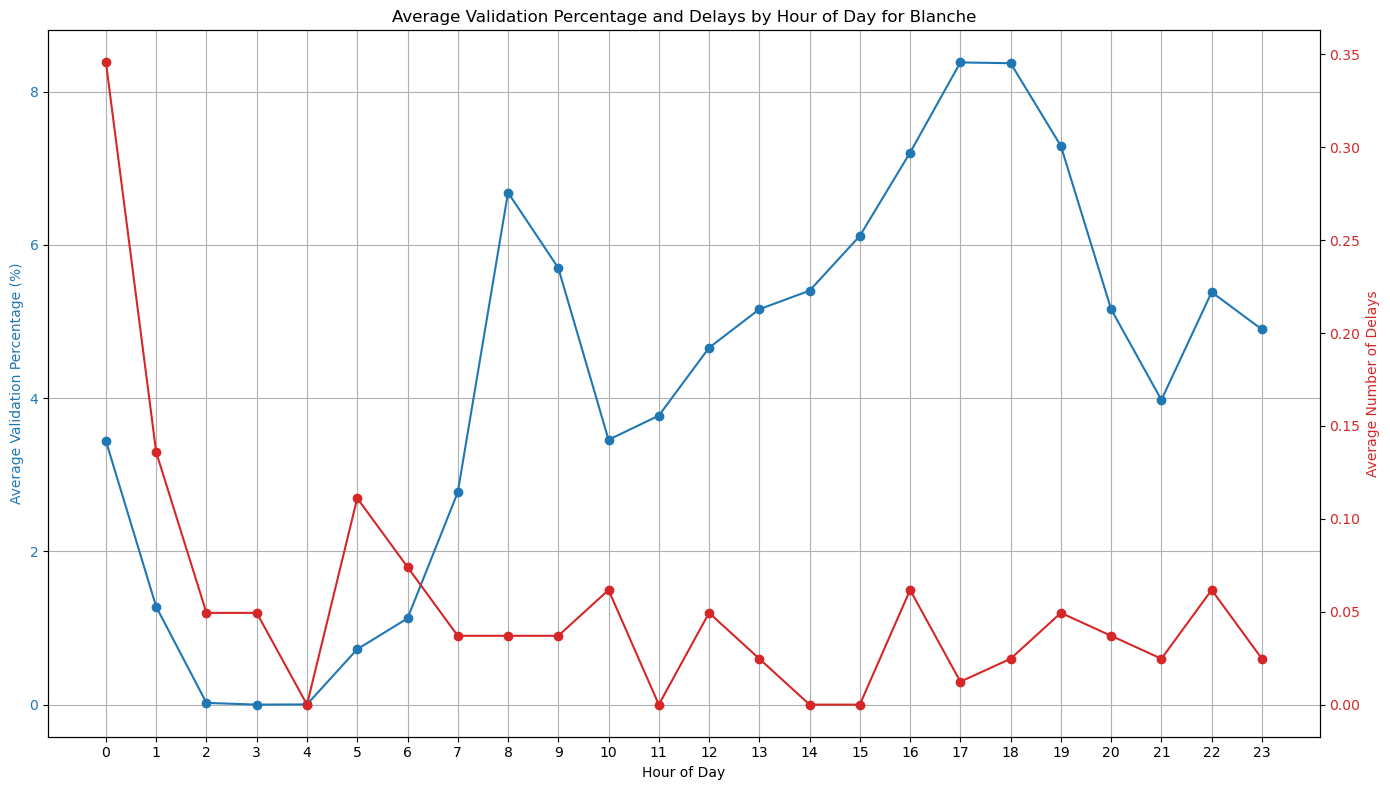

In [332]:
plot_station_metrics(BL)

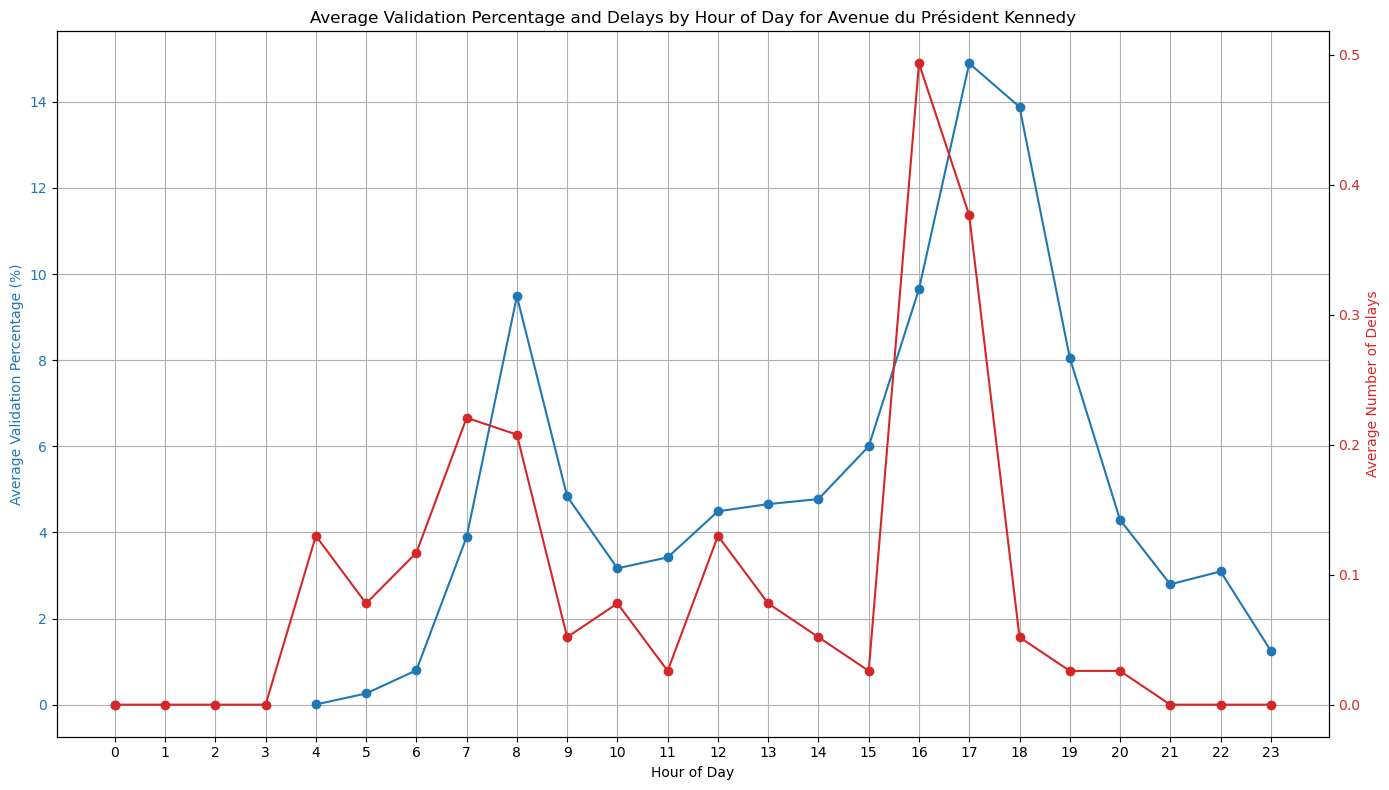

In [339]:
plot_station_metrics(APK)

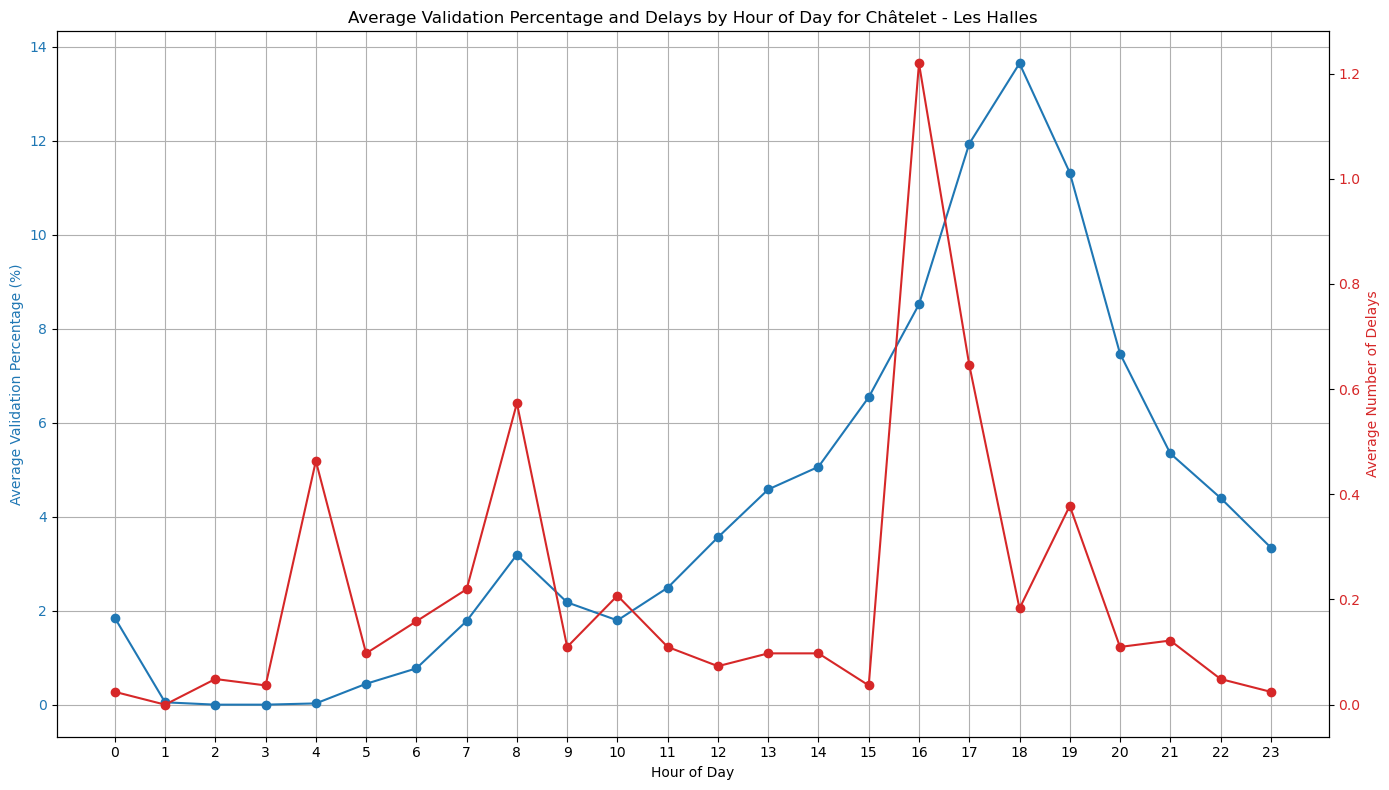

In [341]:
plot_station_metrics(CLH)

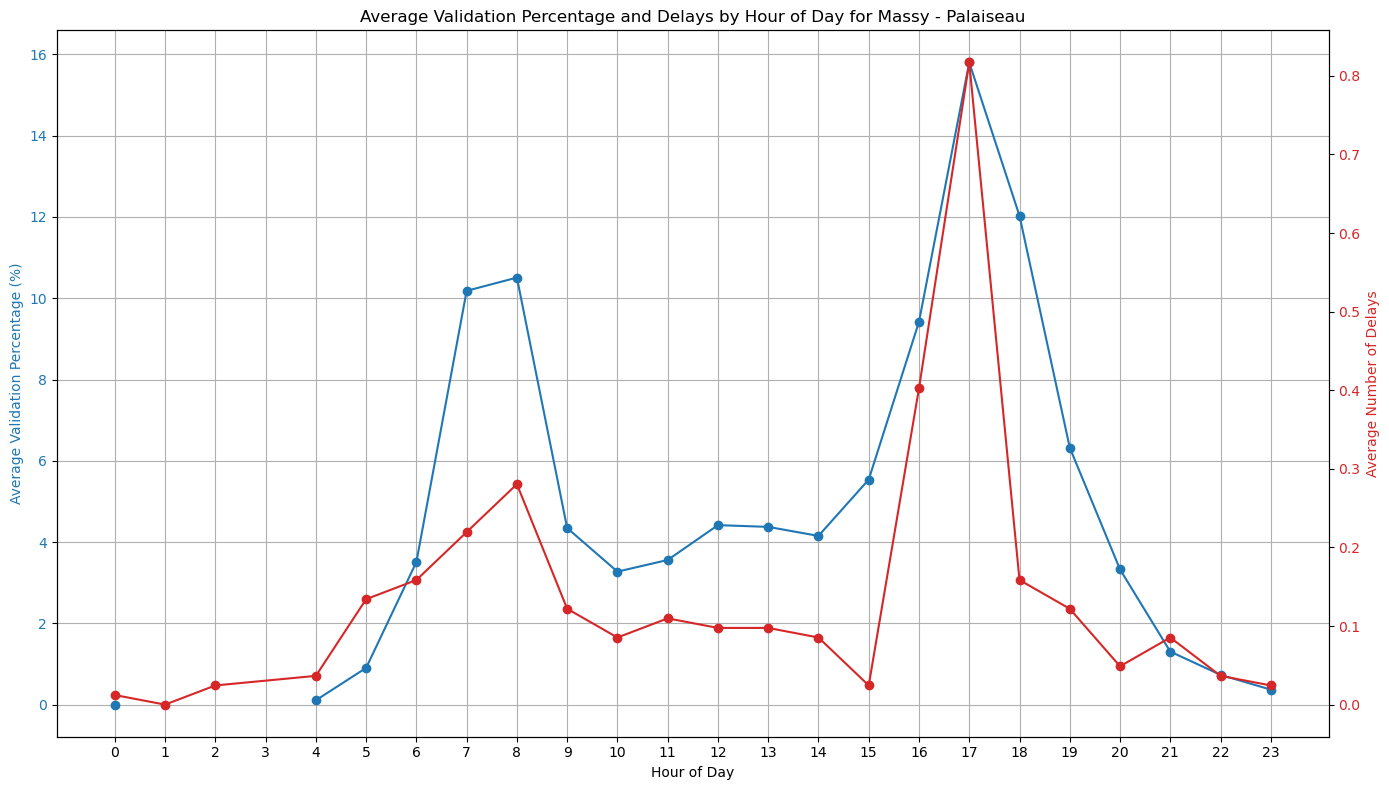

In [343]:
plot_station_metrics(MP)

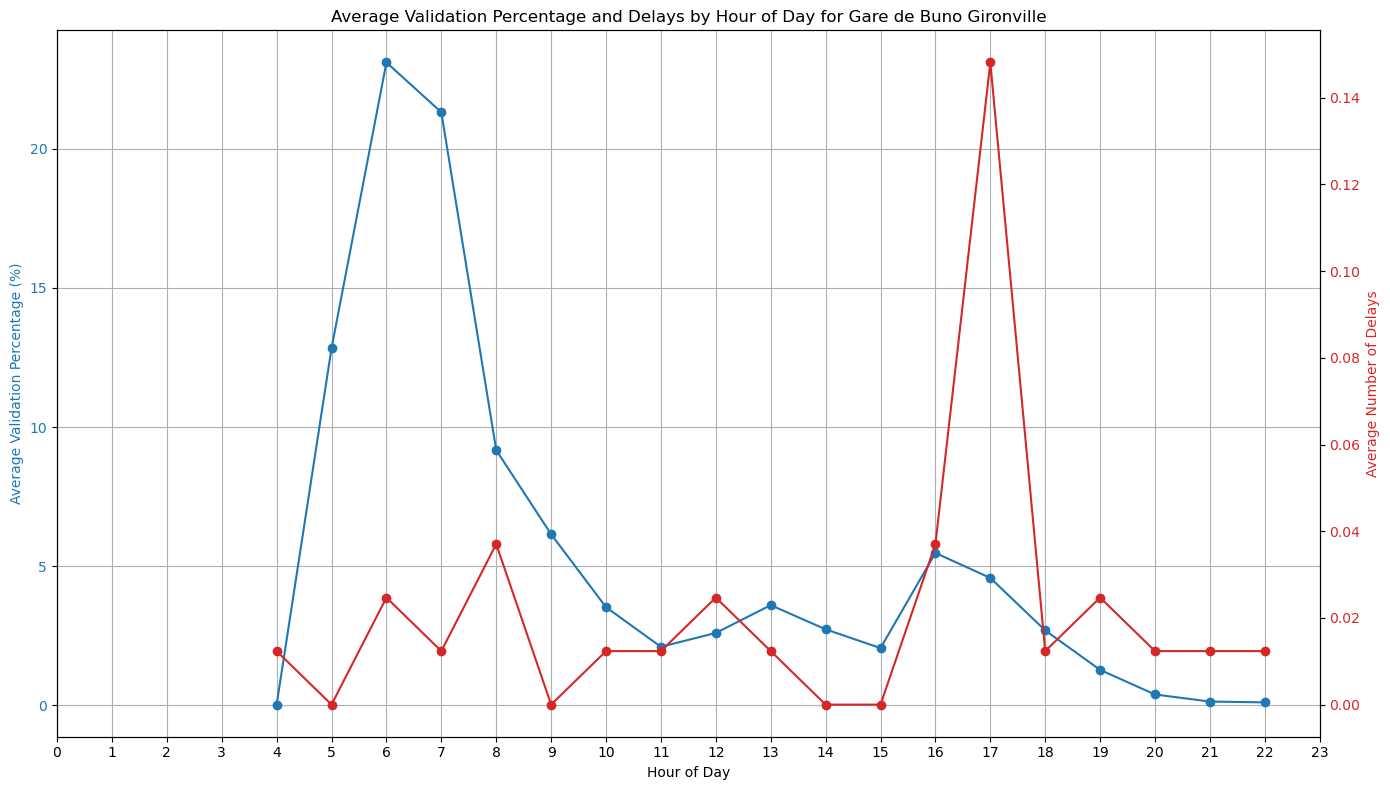

In [345]:
plot_station_metrics(GBG)

## rer (4 stops)

In [337]:
rer_stops = pd.concat([APK, GBG, CLH, MP], ignore_index=True)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


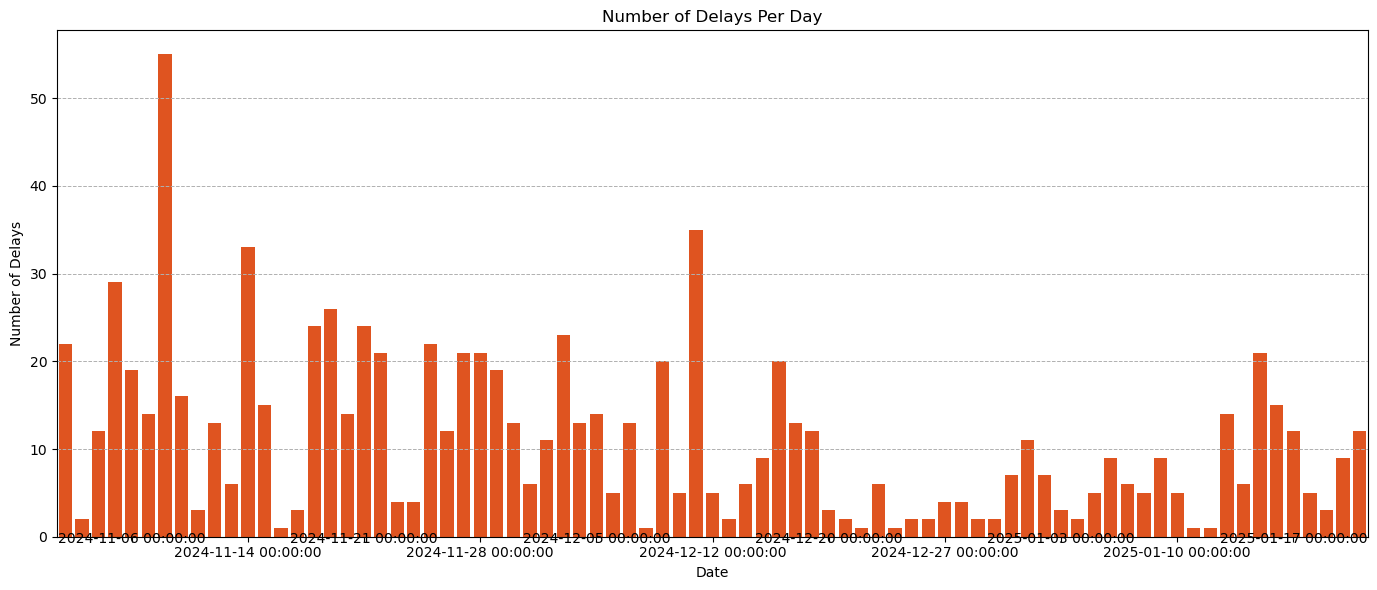

In [301]:
## idk how to format the dates propertly and on axis ticker location

# Ensure the datetime column is in proper format
rer_stops['Date'] = pd.to_datetime(rer_stops['Date'])

# Filter for delayed departures
delayed_rer = rer_stops[rer_stops['departure_status'] == 'delayed']

# Group by date and count the number of delays
delayed_count_per_day = delayed_rer.groupby(delayed_rer['Date'].dt.date).size().reset_index(name='delay_count')

# Rename columns for clarity
delayed_count_per_day.rename(columns={'Date': 'date'}, inplace=True)

# Convert 'date' to datetime for better handling of date ticks
delayed_count_per_day['date'] = pd.to_datetime(delayed_count_per_day['date'])

# Plot as a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=delayed_count_per_day,
    x='date',
    y='delay_count',
    color="#FF4500"  # Custom orange-red color
)

# Set x-axis ticks to be on each Monday
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # Major ticks every Monday

# Get the current axis and set the ticks
ax = plt.gca()
ticks = ax.get_xticks()

# Alternate the height of the ticks
for i, tick in enumerate(ticks):
    if i % 2 == 0:
        ax.get_xticklabels()[i].set_verticalalignment('bottom')  # Lower even-index ticks
    else:
        ax.get_xticklabels()[i].set_verticalalignment('top')  # Raise odd-index ticks

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Delays')
plt.title('Number of Delays Per Day')

# Enable grid for better visibility of bar heights
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig("./Figures/Delays-Per-Day-Weekly-Ticks-Alternating1.png", format='png', dpi=300)
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

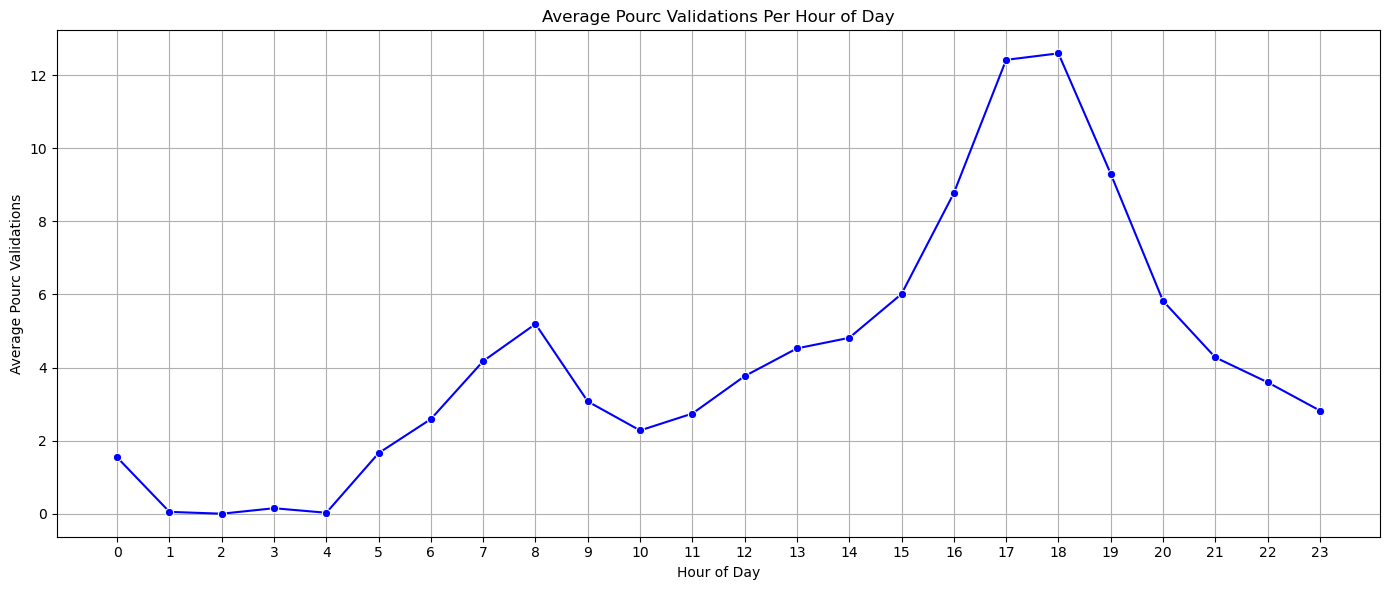

In [303]:
# Ensure the datetime column is in the correct format (if not already)
rer_stops['scheduled_arrival'] = pd.to_datetime(rer_stops['scheduled_arrival'])

# Extract hour from the datetime column
rer_stops['hour'] = rer_stops['scheduled_arrival'].dt.hour

# Group by hour and calculate the average pourc_validations
hourly_validations = rer_stops.groupby('hour')['pourc_validations'].mean().reset_index()

# Plot the hourly average pourc_validations
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=hourly_validations,
    x='hour',
    y='pourc_validations',
    marker='o',
    color='b'  # Blue color for the line
)

# Add labels and title
plt.xlabel('Hour of Day')
plt.ylabel('Average Pourc Validations')
plt.title('Average Pourc Validations Per Hour of Day')

# Set the x-ticks to be from 0 to 23 (representing hours)
plt.xticks(range(24))

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


## metro (4 stops)

In [306]:
metro_stops = pd.concat([CDG, SL, SGP, BL], ignore_index=True)

In [2]:
## for better readability, merge noth/south east/west directions

# Ensure the datetime column is in the correct format (if not already)
metro_stops['real_arrival'] = pd.to_datetime(metro_stops['real_arrival'])

# Filter for delayed departures
delayed_rer = metro_stops[metro_stops['departure_status'] == 'delayed']

# Add a 'day_of_week' column (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) using .loc
delayed_rer.loc[:, 'day_of_week'] = delayed_rer['real_arrival'].dt.dayofweek

# Map numerical days to actual weekday names using .loc
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
delayed_rer.loc[:, 'day_of_week'] = delayed_rer['day_of_week'].map(day_names)

# Group by day of the week and destination_name, then count the number of delays
delayed_count_per_weekday = delayed_rer.groupby(['day_of_week', 'destination_name']).size().reset_index(name='delay_count')

# Calculate the average number of delays per weekday for each destination
average_delays_per_weekday = delayed_count_per_weekday.groupby(['day_of_week', 'destination_name'])['delay_count'].mean().reset_index()

# Sort by weekday order
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_delays_per_weekday['day_of_week'] = pd.Categorical(average_delays_per_weekday['day_of_week'], categories=ordered_days, ordered=True)

# Plot the average delays per weekday for each destination as a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=average_delays_per_weekday,
    x='day_of_week',
    y='delay_count',
    hue='destination_name',
    palette = "tab10"
)

# Add labels and title
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Delays')
plt.title('Average Number of Delays Per Weekday by Destination')

# Rotate x-ticks for better readability
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


NameError: name 'pd' is not defined

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


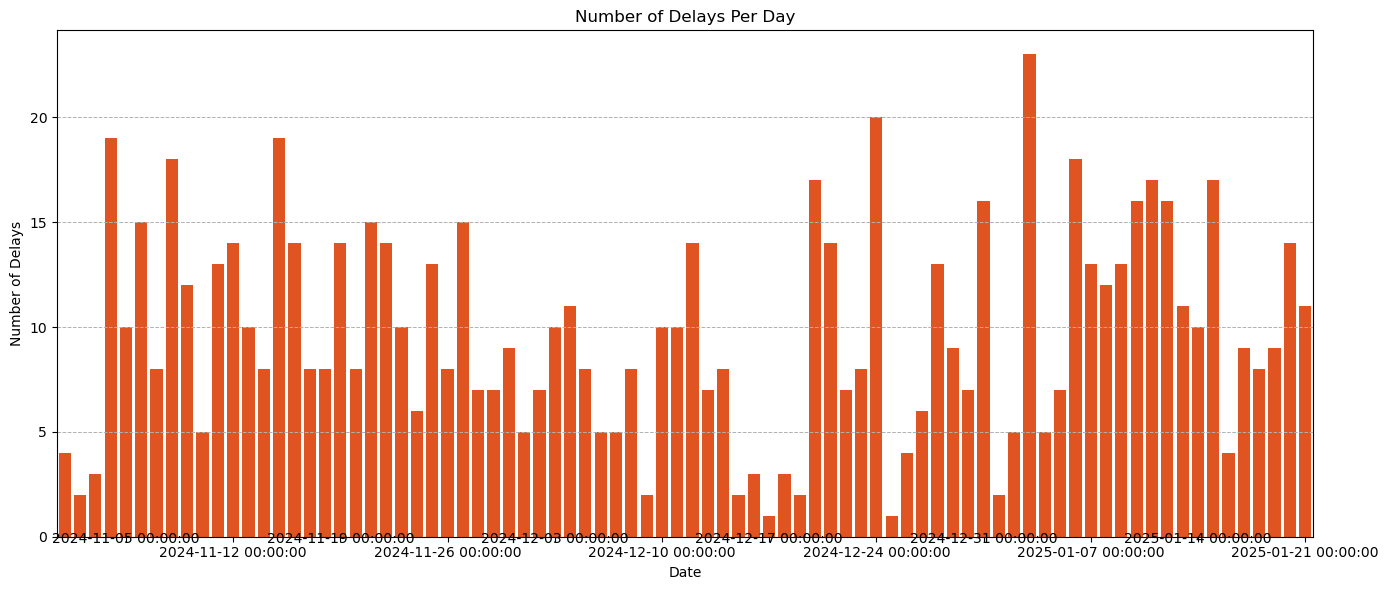

In [309]:
## idk how to format the dates propertly and on axis ticker location

# Ensure the datetime column is in proper format
metro_stops['real_arrival'] = pd.to_datetime(metro_stops['real_arrival'])

# Filter for delayed departures
delayed_metro = metro_stops[metro_stops['departure_status'] == 'delayed']

# Group by date and count the number of delays
delayed_count_per_day = delayed_metro.groupby(delayed_metro['real_arrival'].dt.date).size().reset_index(name='delay_count')

# Rename columns for clarity
delayed_count_per_day.rename(columns={'real_arrival': 'date'}, inplace=True)

# Convert 'date' to datetime for better handling of date ticks
delayed_count_per_day['date'] = pd.to_datetime(delayed_count_per_day['date'])

# Plot as a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=delayed_count_per_day,
    x='date',
    y='delay_count',
    color="#FF4500"  # Custom orange-red color
)

# Set x-axis ticks to be on each Monday
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # Major ticks every Monday

# Get the current axis and set the ticks
ax = plt.gca()
ticks = ax.get_xticks()

# Alternate the height of the ticks
for i, tick in enumerate(ticks):
    if i % 2 == 0:
        ax.get_xticklabels()[i].set_verticalalignment('bottom')  # Lower even-index ticks
    else:
        ax.get_xticklabels()[i].set_verticalalignment('top')  # Raise odd-index ticks

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Delays')
plt.title('Number of Delays Per Day')

# Enable grid for better visibility of bar heights
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig("./Figures/Delays-Per-Day-Weekly-Ticks-Alternating2.png", format='png', dpi=300)
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

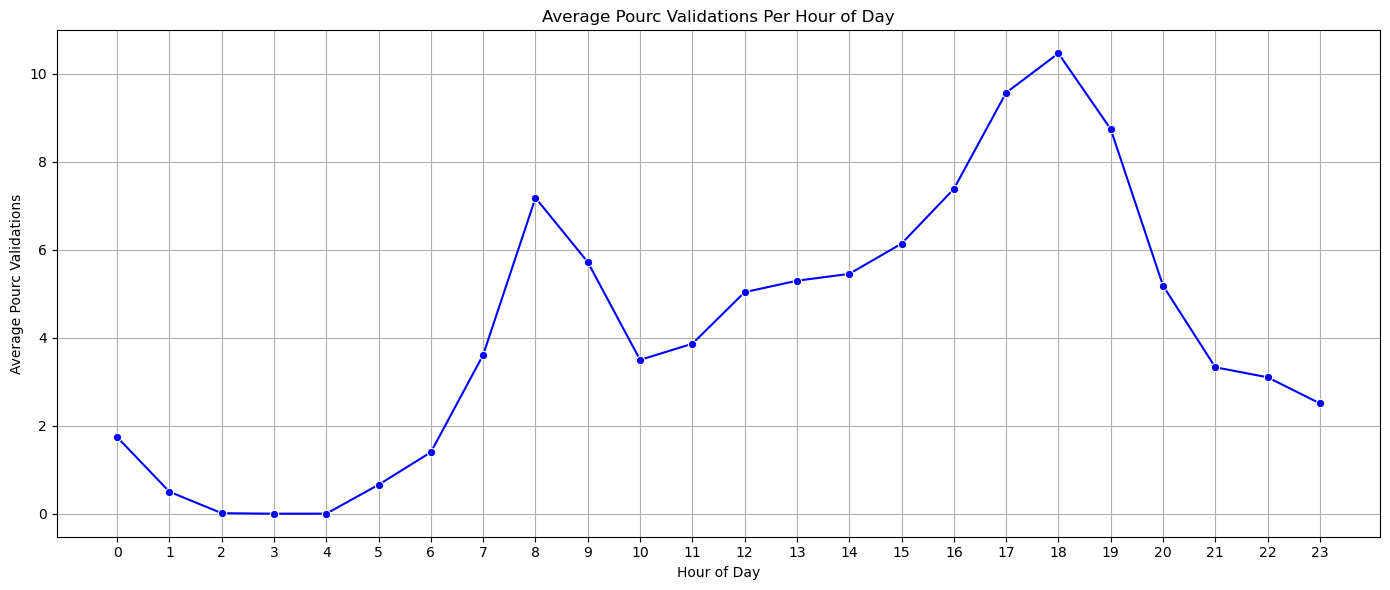

In [311]:
# Ensure the datetime column is in the correct format (if not already)
metro_stops['real_arrival'] = pd.to_datetime(metro_stops['real_arrival'])

# Extract hour from the datetime column
metro_stops['hour'] = metro_stops['real_arrival'].dt.hour

# Group by hour and calculate the average pourc_validations
hourly_validations = metro_stops.groupby('hour')['pourc_validations'].mean().reset_index()

# Plot the hourly average pourc_validations
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=hourly_validations,
    x='hour',
    y='pourc_validations',
    marker='o',
    color='b'  # Blue color for the line
)

# Add labels and title
plt.xlabel('Hour of Day')
plt.ylabel('Average Pourc Validations')
plt.title('Average Pourc Validations Per Hour of Day')

# Set the x-ticks to be from 0 to 23 (representing hours)
plt.xticks(range(24))

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
